Import important parameter

In [1]:
inputsize = 49
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.559786491004146


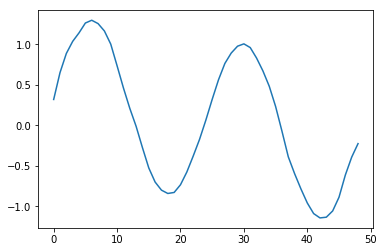

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.26932658877321736


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.6171455219528607
Iteration 200/4000
Upper bound estimation = 0.5935007936952217
Iteration 300/4000
Upper bound estimation = 0.5759390195920736
Iteration 400/4000
Upper bound estimation = 0.5538452868858124
Iteration 500/4000
Upper bound estimation = 0.5301236678040461
Iteration 600/4000
Upper bound estimation = 0.5053693063496187
Iteration 700/4000
Upper bound estimation = 0.4913197939228679
Iteration 800/4000
Upper bound estimation = 0.46646410810612854
Iteration 900/4000
Upper bound estimation = 0.45699034237270875
Iteration 1000/4000
Upper bound estimation = 0.4431907100550223
Iteration 1100/4000
Upper bound estimation = 0.43898118009800446
Iteration 1200/4000
Upper bound estimation = 0.41840109745992227
Iteration 1300/4000
Upper bound estimation = 0.4101941418939533
Iteration 1400/4000
Upper bound estimation = 0.3923008215702385
Iteration 1500/4000
Upper bound estimation = 0.39452580043508845
Iteration 1600/4000
Upper bound estimation =

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.23035682579383462


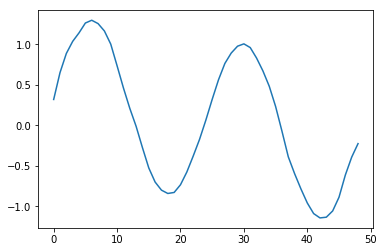

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.26932658877324833


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11942728519194762
L = 0.03
rho = 0.12045366187932477
L = 0.04
rho = 0.12193357014296853
L = 0.05
rho = 0.1236794135950111
L = 0.060000000000000005
rho = 0.1255656591086343
L = 0.07
rho = 0.1275216371912241
L = 0.08
rho = 0.1295098134439036
L = 0.09
rho = 0.1315102013838725
L = 0.09999999999999999
rho = 0.13351187136815948
L = 0.10999999999999999
rho = 0.1355086586153393
L = 0.11999999999999998
rho = 0.13749699581311944
L = 0.12999999999999998
rho = 0.13947478758192697
L = 0.13999999999999999
rho = 0.14144080350103866
L = 0.15
rho = 0.14339433774603239
L = 0.16
rho = 0.14533501108029015
L = 0.17
rho = 0.14726265177479084
L = 0.18000000000000002
rho = 0.1491772218598373
L = 0.19000000000000003
rho = 0.15107877025941774
L = 0.20000000000000004
rho = 0.15296740233154915
L = 0.21000000000000005
rho = 0.1548432596818047
L = 0.22000000000000006
rho = 0.1567065065606303
L = 0.23000000000000007
rho = 0.15855732057006638
L = 0.24000000000000007
rho = 0.1603

the 41 steps
rho = 0.2731706001891206
the 42 steps
rho = 0.2731472698668518
the 43 steps
rho = 0.2731241084001951
the 44 steps
rho = 0.27310111334261034
the 45 steps
rho = 0.27307828228842296
the 46 steps
rho = 0.2730556128722774
the 47 steps
rho = 0.27303310276858
the 48 steps
rho = 0.273010749690975
the 49 steps
rho = 0.2729885513917873
the 50 steps
rho = 0.2729665056614704
the 51 steps
rho = 0.27294461032807177
the 52 steps
rho = 0.2729228632566881
the 53 steps
rho = 0.2729012623489168
the 54 steps
rho = 0.2728798055423161
the 55 steps
rho = 0.2728584908098741
the 56 steps
rho = 0.2728373161594561
the 57 steps
rho = 0.27281627963328897
the 58 steps
rho = 0.272795379307416
the 59 steps
rho = 0.2727746132911756
the 60 steps
rho = 0.27275397972667476
the 61 steps
rho = 0.2727334767882778
the 62 steps
rho = 0.27271310268207083
the 63 steps
rho = 0.27269285564537055
the 64 steps
rho = 0.2726727339462009
the 65 steps
rho = 0.2726527358828048
the 66 steps
rho = 0.27263285978312285
the 67 s

the 182 steps
rho = 0.27087036695962824
the 183 steps
rho = 0.2708583244041656
the 184 steps
rho = 0.27084631958780264
the 185 steps
rho = 0.27083435225683206
the 186 steps
rho = 0.270822422160629
the 187 steps
rho = 0.2708105290515938
the 188 steps
rho = 0.2707986726851107
the 189 steps
rho = 0.27078685281947185
the 190 steps
rho = 0.2707750692158446
the 191 steps
rho = 0.2707633216382108
the 192 steps
rho = 0.2707516098533089
the 193 steps
rho = 0.2707399336305971
the 194 steps
rho = 0.2707282927421942
the 195 steps
rho = 0.2707166869628344
the 196 steps
rho = 0.270705116069826
the 197 steps
rho = 0.2706935798429926
the 198 steps
rho = 0.2706820780646414
the 199 steps
rho = 0.270670610519513
the 200 steps
rho = 0.2706591769947286
the 201 steps
rho = 0.2706477772797666
the 202 steps
rho = 0.2706364111664073
the 203 steps
rho = 0.2706250784486973
the 204 steps
rho = 0.27061377892290134
the 205 steps
rho = 0.27060251238747657
the 206 steps
rho = 0.27059127864302407
the 207 steps
rho = 0

the 329 steps
rho = 0.2694110251633768
the 330 steps
rho = 0.269402756525562
the 331 steps
rho = 0.269394505225841
the 332 steps
rho = 0.2693862711835335
the 333 steps
rho = 0.2693780543183798
the 334 steps
rho = 0.2693698545505213
the 335 steps
rho = 0.26936167180051074
the 336 steps
rho = 0.2693535059893055
the 337 steps
rho = 0.2693453570382518
the 338 steps
rho = 0.26933722486910466
the 339 steps
rho = 0.2693291094040041
the 340 steps
rho = 0.26932101056548635
the 341 steps
rho = 0.26931292827647413
the 342 steps
rho = 0.2693048624602739
the 343 steps
rho = 0.26929681304058106
the 344 steps
rho = 0.26928877994146516
the 345 steps
rho = 0.26928076308737553
the 346 steps
rho = 0.26927276240313963
the 347 steps
rho = 0.2692647778139532
the 348 steps
rho = 0.2692568092453871
the 349 steps
rho = 0.269248856623375
the 350 steps
rho = 0.2692409198742226
the 351 steps
rho = 0.26923299892459235
the 352 steps
rho = 0.2692250937015121
the 353 steps
rho = 0.2692172041323663
the 354 steps
rho =

the 491 steps
rho = 0.26825097301913936
the 492 steps
rho = 0.26824469021832087
the 493 steps
rho = 0.268238415722261
the 494 steps
rho = 0.26823214949469554
the 495 steps
rho = 0.2682258914995477
the 496 steps
rho = 0.2682196417009182
the 497 steps
rho = 0.2682134000631015
the 498 steps
rho = 0.26820716655056015
the 499 steps
rho = 0.2682009411279504
the 500 steps
rho = 0.2681947237601016
the 501 steps
rho = 0.2681885144120273
the 502 steps
rho = 0.2681823130489178
the 503 steps
rho = 0.2681761196361419
the 504 steps
rho = 0.2681699341392433
the 505 steps
rho = 0.26816375652394875
the 506 steps
rho = 0.26815758675615364
the 507 steps
rho = 0.26815142480193094
the 508 steps
rho = 0.26814527062752913
the 509 steps
rho = 0.26813912419936736
the 510 steps
rho = 0.26813298548403885
the 511 steps
rho = 0.26812685444830775
the 512 steps
rho = 0.26812073105910655
the 513 steps
rho = 0.26811461528354313
the 514 steps
rho = 0.2681085070888891
the 515 steps
rho = 0.26810240644259165
the 516 step

the 629 steps
rho = 0.26744927668462015
the 630 steps
rho = 0.2674438650346198
the 631 steps
rho = 0.26743845810437433
the 632 steps
rho = 0.2674330558761702
the 633 steps
rho = 0.2674276583323746
the 634 steps
rho = 0.26742226545545356
the 635 steps
rho = 0.26741687722796037
the 636 steps
rho = 0.267411493632537
the 637 steps
rho = 0.2674061146519142
the 638 steps
rho = 0.26740074026891336
the 639 steps
rho = 0.26739537046644474
the 640 steps
rho = 0.2673900052274998
the 641 steps
rho = 0.26738464453516764
the 642 steps
rho = 0.2673792883726137
the 643 steps
rho = 0.2673739367230959
the 644 steps
rho = 0.2673685895699563
the 645 steps
rho = 0.26736324689662094
the 646 steps
rho = 0.2673579086866019
the 647 steps
rho = 0.2673525749234961
the 648 steps
rho = 0.26734724559098083
the 649 steps
rho = 0.2673419206728212
the 650 steps
rho = 0.2673366001528614
the 651 steps
rho = 0.2673312840150326
the 652 steps
rho = 0.26732597224334187
the 653 steps
rho = 0.2673206648218834
the 654 steps
rh

the 787 steps
rho = 0.2666432803706342
the 788 steps
rho = 0.2666384425569238
the 789 steps
rho = 0.2666336075234284
the 790 steps
rho = 0.2666287752619597
the 791 steps
rho = 0.26662394576437304
the 792 steps
rho = 0.26661911902255814
the 793 steps
rho = 0.2666142950284433
the 794 steps
rho = 0.26660947377399147
the 795 steps
rho = 0.26660465525120386
the 796 steps
rho = 0.26659983945211374
the 797 steps
rho = 0.2665950263687965
the 798 steps
rho = 0.2665902159933592
the 799 steps
rho = 0.266585408317944
the 800 steps
rho = 0.26658060333473177
the 801 steps
rho = 0.266575801035933
the 802 steps
rho = 0.26657100141380047
the 803 steps
rho = 0.26656620446061446
the 804 steps
rho = 0.2665614101686951
the 805 steps
rho = 0.26655661853039386
the 806 steps
rho = 0.2665518295380953
the 807 steps
rho = 0.2665470431842234
the 808 steps
rho = 0.2665422594612297
the 809 steps
rho = 0.2665374783616044
the 810 steps
rho = 0.2665326998778673
the 811 steps
rho = 0.266527924002572
the 812 steps
rho =

the 937 steps
rho = 0.2659448113312955
the 938 steps
rho = 0.26594031601978213
the 939 steps
rho = 0.2659358225832565
the 940 steps
rho = 0.2659313310173561
the 941 steps
rho = 0.2659268413177264
the 942 steps
rho = 0.2659223534800371
the 943 steps
rho = 0.2659178674999724
the 944 steps
rho = 0.26591338337323495
the 945 steps
rho = 0.2659089010955364
the 946 steps
rho = 0.26590442066261544
the 947 steps
rho = 0.2658999420702187
the 948 steps
rho = 0.26589546531411223
the 949 steps
rho = 0.2658909903900781
the 950 steps
rho = 0.26588651729391355
the 951 steps
rho = 0.2658820460214312
the 952 steps
rho = 0.26587757656846006
the 953 steps
rho = 0.2658731089308484
the 954 steps
rho = 0.26586864310445285
the 955 steps
rho = 0.2658641790851532
the 956 steps
rho = 0.2658597168688376
the 957 steps
rho = 0.2658552564514153
the 958 steps
rho = 0.26585079782880955
the 959 steps
rho = 0.26584634099695814
the 960 steps
rho = 0.2658418859518118
the 961 steps
rho = 0.26583743268934146
the 962 steps
r

the 1094 steps
rho = 0.2652595992970863
the 1095 steps
rho = 0.2652553537521101
the 1096 steps
rho = 0.2652511095585682
the 1097 steps
rho = 0.265246866713947
the 1098 steps
rho = 0.2652426252157377
the 1099 steps
rho = 0.26523838506144115
the 1100 steps
rho = 0.26523414624856706
the 1101 steps
rho = 0.26522990877463043
the 1102 steps
rho = 0.26522567263715935
the 1103 steps
rho = 0.2652214378336831
the 1104 steps
rho = 0.26521720436174295
the 1105 steps
rho = 0.2652129722188882
the 1106 steps
rho = 0.2652087414026742
the 1107 steps
rho = 0.2652045119106649
the 1108 steps
rho = 0.2652002837404291
the 1109 steps
rho = 0.26519605688955283
the 1110 steps
rho = 0.2651918313556163
the 1111 steps
rho = 0.26518760713621664
the 1112 steps
rho = 0.2651833842289564
the 1113 steps
rho = 0.26517916263144414
the 1114 steps
rho = 0.2651749423412989
the 1115 steps
rho = 0.26517072335614134
the 1116 steps
rho = 0.2651665056736087
the 1117 steps
rho = 0.26516228929133706
the 1118 steps
rho = 0.26515807

the 1234 steps
rho = 0.2646773573841156
the 1235 steps
rho = 0.26467327971150084
the 1236 steps
rho = 0.26466920310352887
the 1237 steps
rho = 0.26466512755854343
the 1238 steps
rho = 0.26466105307489485
the 1239 steps
rho = 0.26465697965093377
the 1240 steps
rho = 0.26465290728501634
the 1241 steps
rho = 0.2646488359755071
the 1242 steps
rho = 0.26464476572076906
the 1243 steps
rho = 0.26464069651917643
the 1244 steps
rho = 0.26463662836910407
the 1245 steps
rho = 0.264632561268928
the 1246 steps
rho = 0.26462849521703496
the 1247 steps
rho = 0.26462443021181514
the 1248 steps
rho = 0.264620366251658
the 1249 steps
rho = 0.26461630333496333
the 1250 steps
rho = 0.26461224146013224
the 1251 steps
rho = 0.2646081806255705
the 1252 steps
rho = 0.2646041208296875
the 1253 steps
rho = 0.26460006207090103
the 1254 steps
rho = 0.2645960043476276
the 1255 steps
rho = 0.26459194765829064
the 1256 steps
rho = 0.26458789200131827
the 1257 steps
rho = 0.2645838373751421
the 1258 steps
rho = 0.264

the 1382 steps
rho = 0.2640846452485608
the 1383 steps
rho = 0.26408070925164573
the 1384 steps
rho = 0.26407677411610053
the 1385 steps
rho = 0.26407283984079244
the 1386 steps
rho = 0.26406890642459024
the 1387 steps
rho = 0.2640649738663661
the 1388 steps
rho = 0.2640610421649938
the 1389 steps
rho = 0.26405711131935233
the 1390 steps
rho = 0.26405318132831956
the 1391 steps
rho = 0.2640492521907805
the 1392 steps
rho = 0.2640453239056161
the 1393 steps
rho = 0.2640413964717184
the 1394 steps
rho = 0.26403746988797716
the 1395 steps
rho = 0.26403354415328467
the 1396 steps
rho = 0.26402961926653445
the 1397 steps
rho = 0.26402569522662844
the 1398 steps
rho = 0.2640217720324665
the 1399 steps
rho = 0.26401784968294795
the 1400 steps
rho = 0.2640139281769837
the 1401 steps
rho = 0.26401000751347964
the 1402 steps
rho = 0.26400608769134787
the 1403 steps
rho = 0.2640021687095008
the 1404 steps
rho = 0.26399825056685716
the 1405 steps
rho = 0.2639943332623307
the 1406 steps
rho = 0.263

the 1521 steps
rho = 0.26354534323924167
the 1522 steps
rho = 0.26354151715474466
the 1523 steps
rho = 0.2635376917962985
the 1524 steps
rho = 0.2635338671630662
the 1525 steps
rho = 0.2635300432542177
the 1526 steps
rho = 0.26352622006892173
the 1527 steps
rho = 0.2635223976063484
the 1528 steps
rho = 0.2635185758656717
the 1529 steps
rho = 0.2635147548460654
the 1530 steps
rho = 0.26351093454670615
the 1531 steps
rho = 0.2635071149667731
the 1532 steps
rho = 0.2635032961054447
the 1533 steps
rho = 0.26349947796190176
the 1534 steps
rho = 0.26349566053532725
the 1535 steps
rho = 0.263491843824906
the 1536 steps
rho = 0.26348802782982456
the 1537 steps
rho = 0.26348421254927096
the 1538 steps
rho = 0.2634803979824333
the 1539 steps
rho = 0.26347658412850294
the 1540 steps
rho = 0.26347277098667493
the 1541 steps
rho = 0.2634689585561418
the 1542 steps
rho = 0.2634651468361
the 1543 steps
rho = 0.26346133582574616
the 1544 steps
rho = 0.26345752552428037
the 1545 steps
rho = 0.263453715

the 1662 steps
rho = 0.26301267493724423
the 1663 steps
rho = 0.26300894370144584
the 1664 steps
rho = 0.26300521308886876
the 1665 steps
rho = 0.2630014830988759
the 1666 steps
rho = 0.26299775373083056
the 1667 steps
rho = 0.2629940249840995
the 1668 steps
rho = 0.262990296858047
the 1669 steps
rho = 0.2629865693520438
the 1670 steps
rho = 0.2629828424654568
the 1671 steps
rho = 0.2629791161976584
the 1672 steps
rho = 0.26297539054801844
the 1673 steps
rho = 0.26297166551590984
the 1674 steps
rho = 0.2629679411007044
the 1675 steps
rho = 0.262964217301779
the 1676 steps
rho = 0.2629604941185081
the 1677 steps
rho = 0.26295677155026825
the 1678 steps
rho = 0.2629530495964399
the 1679 steps
rho = 0.2629493282563987
the 1680 steps
rho = 0.2629456075295261
the 1681 steps
rho = 0.262941887415203
the 1682 steps
rho = 0.2629381679128119
the 1683 steps
rho = 0.2629344490217371
the 1684 steps
rho = 0.2629307307413618
the 1685 steps
rho = 0.26292701307106936
the 1686 steps
rho = 0.262923296010

the 1811 steps
rho = 0.26246326924615704
the 1812 steps
rho = 0.2624596244092312
the 1813 steps
rho = 0.26245598011172094
the 1814 steps
rho = 0.26245233635312837
the 1815 steps
rho = 0.2624486931329573
the 1816 steps
rho = 0.26244505045071653
the 1817 steps
rho = 0.2624414083059079
the 1818 steps
rho = 0.26243776669804103
the 1819 steps
rho = 0.2624341256266244
the 1820 steps
rho = 0.26243048509116373
the 1821 steps
rho = 0.2624268450911718
the 1822 steps
rho = 0.2624232056261538
the 1823 steps
rho = 0.2624195666956223
the 1824 steps
rho = 0.2624159282990922
the 1825 steps
rho = 0.262412290436072
the 1826 steps
rho = 0.26240865310607603
the 1827 steps
rho = 0.2624050163086183
the 1828 steps
rho = 0.26240138004321173
the 1829 steps
rho = 0.2623977443093734
the 1830 steps
rho = 0.2623941091066192
the 1831 steps
rho = 0.2623904744344658
the 1832 steps
rho = 0.26238684029242826
the 1833 steps
rho = 0.26238320668002935
the 1834 steps
rho = 0.2623795735967854
the 1835 steps
rho = 0.26237594

the 1967 steps
rho = 0.26190090550679035
the 1968 steps
rho = 0.2618973392628757
the 1969 steps
rho = 0.26189377348936854
the 1970 steps
rho = 0.2618902081858726
the 1971 steps
rho = 0.2618866433519955
the 1972 steps
rho = 0.26188307898734603
the 1973 steps
rho = 0.26187951509153123
the 1974 steps
rho = 0.2618759516641613
the 1975 steps
rho = 0.2618723887048415
the 1976 steps
rho = 0.2618688262131851
the 1977 steps
rho = 0.26186526418879885
the 1978 steps
rho = 0.26186170263129654
the 1979 steps
rho = 0.26185814154028864
the 1980 steps
rho = 0.26185458091538716
the 1981 steps
rho = 0.26185102075620365
the 1982 steps
rho = 0.2618474610623507
the 1983 steps
rho = 0.2618439018334416
the 1984 steps
rho = 0.26184034306909254
the 1985 steps
rho = 0.26183678476891553
the 1986 steps
rho = 0.26183322693252675
the 1987 steps
rho = 0.2618296695595423
the 1988 steps
rho = 0.26182611264957606
the 1989 steps
rho = 0.26182255620224615
the 1990 steps
rho = 0.2618190002171706
the 1991 steps
rho = 0.261

the 2104 steps
rho = 0.2614165547333843
the 2105 steps
rho = 0.2614130494850061
the 2106 steps
rho = 0.2614095446578318
the 2107 steps
rho = 0.261406040251533
the 2108 steps
rho = 0.26140253626578003
the 2109 steps
rho = 0.2613990327002509
the 2110 steps
rho = 0.2613955295546177
the 2111 steps
rho = 0.2613920268285548
the 2112 steps
rho = 0.2613885245217381
the 2113 steps
rho = 0.2613850226338439
the 2114 steps
rho = 0.261381521164547
the 2115 steps
rho = 0.2613780201135243
the 2116 steps
rho = 0.26137451948045176
the 2117 steps
rho = 0.26137101926500705
the 2118 steps
rho = 0.26136751946687
the 2119 steps
rho = 0.2613640200857147
the 2120 steps
rho = 0.2613605211212216
the 2121 steps
rho = 0.26135702257307103
the 2122 steps
rho = 0.26135352444093973
the 2123 steps
rho = 0.2613500267245098
the 2124 steps
rho = 0.2613465294234589
the 2125 steps
rho = 0.26134303253747043
the 2126 steps
rho = 0.26133953606622295
the 2127 steps
rho = 0.26133604000939925
the 2128 steps
rho = 0.2613325443666

the 2253 steps
rho = 0.26089874824102377
the 2254 steps
rho = 0.2608953023631117
the 2255 steps
rho = 0.2608918568620143
the 2256 steps
rho = 0.2608884117374636
the 2257 steps
rho = 0.260884966989187
the 2258 steps
rho = 0.26088152261691533
the 2259 steps
rho = 0.26087807862037987
the 2260 steps
rho = 0.26087463499930913
the 2261 steps
rho = 0.2608711917534334
the 2262 steps
rho = 0.26086774888248987
the 2263 steps
rho = 0.26086430638620256
the 2264 steps
rho = 0.2608608642643072
the 2265 steps
rho = 0.26085742251653654
the 2266 steps
rho = 0.26085398114262154
the 2267 steps
rho = 0.2608505401422962
the 2268 steps
rho = 0.2608470995152921
the 2269 steps
rho = 0.2608436592613458
the 2270 steps
rho = 0.2608402193801884
the 2271 steps
rho = 0.26083677987155446
the 2272 steps
rho = 0.26083334073518116
the 2273 steps
rho = 0.26082990197080086
the 2274 steps
rho = 0.2608264635781485
the 2275 steps
rho = 0.26082302555696163
the 2276 steps
rho = 0.2608195879069729
the 2277 steps
rho = 0.260816

the 2399 steps
rho = 0.26039950691046715
the 2400 steps
rho = 0.26039611334244367
the 2401 steps
rho = 0.2603927201149928
the 2402 steps
rho = 0.260389327227885
the 2403 steps
rho = 0.2603859346808936
the 2404 steps
rho = 0.26038254247379394
the 2405 steps
rho = 0.26037915060635797
the 2406 steps
rho = 0.26037575907835914
the 2407 steps
rho = 0.26037236788957374
the 2408 steps
rho = 0.26036897703977363
the 2409 steps
rho = 0.26036558652873776
the 2410 steps
rho = 0.2603621963562353
the 2411 steps
rho = 0.26035880652204785
the 2412 steps
rho = 0.26035541702594595
the 2413 steps
rho = 0.26035202786770745
the 2414 steps
rho = 0.2603486390471102
the 2415 steps
rho = 0.2603452505639269
the 2416 steps
rho = 0.2603418624179377
the 2417 steps
rho = 0.2603384746089167
the 2418 steps
rho = 0.26033508713664244
the 2419 steps
rho = 0.2603317000008916
the 2420 steps
rho = 0.2603283132014414
the 2421 steps
rho = 0.2603249267380722
the 2422 steps
rho = 0.26032154061056023
the 2423 steps
rho = 0.26031

the 2551 steps
rho = 0.25988746813755986
the 2552 steps
rho = 0.2598841238757633
the 2553 steps
rho = 0.2598807799228812
the 2554 steps
rho = 0.2598774362787211
the 2555 steps
rho = 0.25987409294309166
the 2556 steps
rho = 0.2598707499158064
the 2557 steps
rho = 0.25986740719667356
the 2558 steps
rho = 0.2598640647855029
the 2559 steps
rho = 0.2598607226821037
the 2560 steps
rho = 0.2598573808862886
the 2561 steps
rho = 0.25985403939786894
the 2562 steps
rho = 0.259850698216656
the 2563 steps
rho = 0.25984735734245995
the 2564 steps
rho = 0.25984401677509256
the 2565 steps
rho = 0.2598406765143652
the 2566 steps
rho = 0.25983733656009156
the 2567 steps
rho = 0.259833996912084
the 2568 steps
rho = 0.2598306575701541
the 2569 steps
rho = 0.259827318534113
the 2570 steps
rho = 0.2598239798037753
the 2571 steps
rho = 0.25982064137895566
the 2572 steps
rho = 0.25981730325946367
the 2573 steps
rho = 0.25981396544511465
the 2574 steps
rho = 0.2598106279357243
the 2575 steps
rho = 0.2598072907

the 2700 steps
rho = 0.25939248036141543
the 2701 steps
rho = 0.25938918013794693
the 2702 steps
rho = 0.2593858801972324
the 2703 steps
rho = 0.25938258053910984
the 2704 steps
rho = 0.25937928116341824
the 2705 steps
rho = 0.2593759820699966
the 2706 steps
rho = 0.25937268325868384
the 2707 steps
rho = 0.25936938472932064
the 2708 steps
rho = 0.25936608648174414
the 2709 steps
rho = 0.2593627885157948
the 2710 steps
rho = 0.2593594908313139
the 2711 steps
rho = 0.25935619342813954
the 2712 steps
rho = 0.2593528963061137
the 2713 steps
rho = 0.2593495994650759
the 2714 steps
rho = 0.2593463029048671
the 2715 steps
rho = 0.2593430066253261
the 2716 steps
rho = 0.2593397106262965
the 2717 steps
rho = 0.25933641490761844
the 2718 steps
rho = 0.2593331194691307
the 2719 steps
rho = 0.25932982431067864
the 2720 steps
rho = 0.2593265294321032
the 2721 steps
rho = 0.2593232348332422
the 2722 steps
rho = 0.25931994051394314
the 2723 steps
rho = 0.2593166464740444
the 2724 steps
rho = 0.259313

the 2849 steps
rho = 0.2589037808726179
the 2850 steps
rho = 0.25890052109115247
the 2851 steps
rho = 0.25889726157022713
the 2852 steps
rho = 0.2588940023097016
the 2853 steps
rho = 0.2588907433094405
the 2854 steps
rho = 0.2588874845693041
the 2855 steps
rho = 0.25888422608915845
the 2856 steps
rho = 0.25888096786886433
the 2857 steps
rho = 0.2588777099082859
the 2858 steps
rho = 0.2588744522072855
the 2859 steps
rho = 0.25887119476573095
the 2860 steps
rho = 0.25886793758348187
the 2861 steps
rho = 0.25886468066040225
the 2862 steps
rho = 0.25886142399635864
the 2863 steps
rho = 0.25885816759121333
the 2864 steps
rho = 0.2588549114448302
the 2865 steps
rho = 0.25885165555707496
the 2866 steps
rho = 0.2588483999278122
the 2867 steps
rho = 0.2588451445569058
the 2868 steps
rho = 0.25884188944422254
the 2869 steps
rho = 0.25883863458962475
the 2870 steps
rho = 0.25883537999297906
the 2871 steps
rho = 0.2588321256541509
the 2872 steps
rho = 0.25882887157300555
the 2873 steps
rho = 0.258

the 2994 steps
rho = 0.2584337666846358
the 2995 steps
rho = 0.2584305433161004
the 2996 steps
rho = 0.2584273201896148
the 2997 steps
rho = 0.2584240973050609
the 2998 steps
rho = 0.2584208746623218
the 2999 steps
rho = 0.2584176522612777
the 3000 steps
rho = 0.25841443010181386
the 3001 steps
rho = 0.2584112081838095
the 3002 steps
rho = 0.2584079865071495
the 3003 steps
rho = 0.25840476507171606
the 3004 steps
rho = 0.2584015438773926
the 3005 steps
rho = 0.2583983229240602
the 3006 steps
rho = 0.25839510221160195
the 3007 steps
rho = 0.25839188173990374
the 3008 steps
rho = 0.25838866150884615
the 3009 steps
rho = 0.2583854415183139
the 3010 steps
rho = 0.25838222176819003
the 3011 steps
rho = 0.25837900225835886
the 3012 steps
rho = 0.2583757829887043
the 3013 steps
rho = 0.2583725639591071
the 3014 steps
rho = 0.2583693451694571
the 3015 steps
rho = 0.2583661266196339
the 3016 steps
rho = 0.25836290830952224
the 3017 steps
rho = 0.2583596902390094
the 3018 steps
rho = 0.258356472

the 3140 steps
rho = 0.25796565915195335
the 3141 steps
rho = 0.2579624699328173
the 3142 steps
rho = 0.25795928093971854
the 3143 steps
rho = 0.2579560921725585
the 3144 steps
rho = 0.25795290363123324
the 3145 steps
rho = 0.25794971531564315
the 3146 steps
rho = 0.25794652722568745
the 3147 steps
rho = 0.2579433393612618
the 3148 steps
rho = 0.25794015172226603
the 3149 steps
rho = 0.25793696430860097
the 3150 steps
rho = 0.25793377712016446
the 3151 steps
rho = 0.25793059015685404
the 3152 steps
rho = 0.25792740341857345
the 3153 steps
rho = 0.2579242169052179
the 3154 steps
rho = 0.25792103061668803
the 3155 steps
rho = 0.25791784455288386
the 3156 steps
rho = 0.25791465871370534
the 3157 steps
rho = 0.2579114730990517
the 3158 steps
rho = 0.25790828770882224
the 3159 steps
rho = 0.25790510254291865
the 3160 steps
rho = 0.2579019176012388
the 3161 steps
rho = 0.2578987328836844
the 3162 steps
rho = 0.2578955483901556
the 3163 steps
rho = 0.25789236412055344
the 3164 steps
rho = 0.2

the 3279 steps
rho = 0.2575244825969623
the 3280 steps
rho = 0.2575213238657115
the 3281 steps
rho = 0.25751816534731076
the 3282 steps
rho = 0.25751500704166674
the 3283 steps
rho = 0.2575118489486953
the 3284 steps
rho = 0.25750869106830593
the 3285 steps
rho = 0.2575055334004127
the 3286 steps
rho = 0.25750237594492525
the 3287 steps
rho = 0.2574992187017575
the 3288 steps
rho = 0.25749606167081845
the 3289 steps
rho = 0.2574929048520244
the 3290 steps
rho = 0.2574897482452851
the 3291 steps
rho = 0.25748659185051226
the 3292 steps
rho = 0.25748343566762105
the 3293 steps
rho = 0.25748027969652254
the 3294 steps
rho = 0.2574771239371304
the 3295 steps
rho = 0.25747396838935543
the 3296 steps
rho = 0.2574708130531109
the 3297 steps
rho = 0.2574676579283114
the 3298 steps
rho = 0.25746450301486873
the 3299 steps
rho = 0.2574613483126945
the 3300 steps
rho = 0.257458193821705
the 3301 steps
rho = 0.2574550395418118
the 3302 steps
rho = 0.2574518854729286
the 3303 steps
rho = 0.25744873

the 3430 steps
rho = 0.2570498767361648
the 3431 steps
rho = 0.25704674919150566
the 3432 steps
rho = 0.25704362184729435
the 3433 steps
rho = 0.2570404947034522
the 3434 steps
rho = 0.257037367759906
the 3435 steps
rho = 0.257034241016579
the 3436 steps
rho = 0.25703111447339566
the 3437 steps
rho = 0.2570279881302795
the 3438 steps
rho = 0.2570248619871531
the 3439 steps
rho = 0.25702173604394546
the 3440 steps
rho = 0.257018610300576
the 3441 steps
rho = 0.2570154847569732
the 3442 steps
rho = 0.2570123594130591
the 3443 steps
rho = 0.25700923426875877
the 3444 steps
rho = 0.25700610932399554
the 3445 steps
rho = 0.25700298457870024
the 3446 steps
rho = 0.2569998600327887
the 3447 steps
rho = 0.25699673568619424
the 3448 steps
rho = 0.2569936115388375
the 3449 steps
rho = 0.2569904875906437
the 3450 steps
rho = 0.25698736384153803
the 3451 steps
rho = 0.25698424029144773
the 3452 steps
rho = 0.25698111694029624
the 3453 steps
rho = 0.2569779937880091
the 3454 steps
rho = 0.256974870

the 3572 steps
rho = 0.2566077377049335
the 3573 steps
rho = 0.25660463789582716
the 3574 steps
rho = 0.2566015382770794
the 3575 steps
rho = 0.256598438848625
the 3576 steps
rho = 0.2565953396103969
the 3577 steps
rho = 0.25659224056232793
the 3578 steps
rho = 0.2565891417043529
the 3579 steps
rho = 0.25658604303640686
the 3580 steps
rho = 0.2565829445584249
the 3581 steps
rho = 0.25657984627033836
the 3582 steps
rho = 0.2565767481720825
the 3583 steps
rho = 0.25657365026359313
the 3584 steps
rho = 0.25657055254480354
the 3585 steps
rho = 0.2565674550156464
the 3586 steps
rho = 0.2565643576760593
the 3587 steps
rho = 0.256561260525977
the 3588 steps
rho = 0.25655816356533023
the 3589 steps
rho = 0.2565550667940589
the 3590 steps
rho = 0.25655197021209325
the 3591 steps
rho = 0.2565488738193718
the 3592 steps
rho = 0.2565457776158265
the 3593 steps
rho = 0.25654268160139376
the 3594 steps
rho = 0.2565395857760095
the 3595 steps
rho = 0.2565364901396056
the 3596 steps
rho = 0.2565333946

the 3725 steps
rho = 0.2561356430611773
the 3726 steps
rho = 0.256132571644216
the 3727 steps
rho = 0.25612950040820853
the 3728 steps
rho = 0.25612642935309876
the 3729 steps
rho = 0.2561233584788288
the 3730 steps
rho = 0.2561202877853427
the 3731 steps
rho = 0.2561172172725857
the 3732 steps
rho = 0.25611414694049744
the 3733 steps
rho = 0.2561110767890221
the 3734 steps
rho = 0.25610800681810425
the 3735 steps
rho = 0.25610493702768505
the 3736 steps
rho = 0.25610186741771257
the 3737 steps
rho = 0.256098797988126
the 3738 steps
rho = 0.2560957287388719
the 3739 steps
rho = 0.25609265966989164
the 3740 steps
rho = 0.25608959078112825
the 3741 steps
rho = 0.256086522072528
the 3742 steps
rho = 0.25608345354403483
the 3743 steps
rho = 0.2560803851955901
the 3744 steps
rho = 0.25607731702714115
the 3745 steps
rho = 0.256074249038629
the 3746 steps
rho = 0.2560711812299991
the 3747 steps
rho = 0.2560681136011943
the 3748 steps
rho = 0.2560650461521607
the 3749 steps
rho = 0.25606197888

the 3876 steps
rho = 0.2556738775074017
the 3877 steps
rho = 0.25567083279993286
the 3878 steps
rho = 0.2556677882654203
the 3879 steps
rho = 0.2556647439038179
the 3880 steps
rho = 0.2556616997150738
the 3881 steps
rho = 0.25565865569914004
the 3882 steps
rho = 0.25565561185596825
the 3883 steps
rho = 0.25565256818550847
the 3884 steps
rho = 0.25564952468771196
the 3885 steps
rho = 0.2556464813625317
the 3886 steps
rho = 0.2556434382099164
the 3887 steps
rho = 0.25564039522981946
the 3888 steps
rho = 0.2556373524221904
the 3889 steps
rho = 0.25563430978698026
the 3890 steps
rho = 0.2556312673241427
the 3891 steps
rho = 0.2556282250336271
the 3892 steps
rho = 0.25562518291538544
the 3893 steps
rho = 0.2556221409693714
the 3894 steps
rho = 0.2556190991955341
the 3895 steps
rho = 0.2556160575938256
the 3896 steps
rho = 0.25561301616419785
the 3897 steps
rho = 0.2556099749066013
the 3898 steps
rho = 0.2556069338209901
the 3899 steps
rho = 0.255603892907316
the 3900 steps
rho = 0.255600852

the 4029 steps
rho = 0.2552100206879209
the 4030 steps
rho = 0.25520700189881507
the 4031 steps
rho = 0.25520398327568045
the 4032 steps
rho = 0.25520096481847604
the 4033 steps
rho = 0.25519794652715916
the 4034 steps
rho = 0.25519492840168734
the 4035 steps
rho = 0.2551919104420191
the 4036 steps
rho = 0.25518889264811134
the 4037 steps
rho = 0.2551858750199225
the 4038 steps
rho = 0.25518285755741005
the 4039 steps
rho = 0.2551798402605329
the 4040 steps
rho = 0.2551768231292479
the 4041 steps
rho = 0.2551738061635131
the 4042 steps
rho = 0.25517078936328824
the 4043 steps
rho = 0.2551677727285294
the 4044 steps
rho = 0.25516475625919605
the 4045 steps
rho = 0.2551617399552458
the 4046 steps
rho = 0.25515872381663857
the 4047 steps
rho = 0.2551557078433288
the 4048 steps
rho = 0.25515269203527907
the 4049 steps
rho = 0.2551496763924442
the 4050 steps
rho = 0.25514666091478455
the 4051 steps
rho = 0.25514364560225905
the 4052 steps
rho = 0.25514063045482455
the 4053 steps
rho = 0.255

the 4169 steps
rho = 0.2547889867880978
the 4170 steps
rho = 0.2547859908409545
the 4171 steps
rho = 0.25478299505423774
the 4172 steps
rho = 0.2547799994279115
the 4173 steps
rho = 0.25477700396193464
the 4174 steps
rho = 0.25477400865627636
the 4175 steps
rho = 0.2547710135108969
the 4176 steps
rho = 0.25476801852575665
the 4177 steps
rho = 0.25476502370082404
the 4178 steps
rho = 0.2547620290360601
the 4179 steps
rho = 0.2547590345314265
the 4180 steps
rho = 0.2547560401868892
the 4181 steps
rho = 0.25475304600240767
the 4182 steps
rho = 0.2547500519779495
the 4183 steps
rho = 0.2547470581134761
the 4184 steps
rho = 0.2547440644089501
the 4185 steps
rho = 0.25474107086433745
the 4186 steps
rho = 0.25473807747959887
the 4187 steps
rho = 0.2547350842547005
the 4188 steps
rho = 0.2547320911896047
the 4189 steps
rho = 0.2547290982842744
the 4190 steps
rho = 0.2547261055386738
the 4191 steps
rho = 0.254723112952766
the 4192 steps
rho = 0.2547201205265152
the 4193 steps
rho = 0.2547171282

the 4322 steps
rho = 0.2543324514157564
the 4323 steps
rho = 0.25432947960359104
the 4324 steps
rho = 0.25432650794658357
the 4325 steps
rho = 0.2543235364446997
the 4326 steps
rho = 0.25432056509790696
the 4327 steps
rho = 0.254317593906174
the 4328 steps
rho = 0.25431462286946904
the 4329 steps
rho = 0.2543116519877602
the 4330 steps
rho = 0.2543086812610153
the 4331 steps
rho = 0.2543057106892031
the 4332 steps
rho = 0.2543027402722912
the 4333 steps
rho = 0.254299770010248
the 4334 steps
rho = 0.2542967999030416
the 4335 steps
rho = 0.2542938299506401
the 4336 steps
rho = 0.2542908601530128
the 4337 steps
rho = 0.2542878905101266
the 4338 steps
rho = 0.25428492102195194
the 4339 steps
rho = 0.2542819516884556
the 4340 steps
rho = 0.25427898250960507
the 4341 steps
rho = 0.25427601348537215
the 4342 steps
rho = 0.25427304461572053
the 4343 steps
rho = 0.2542700759006229
the 4344 steps
rho = 0.25426710734004637
the 4345 steps
rho = 0.2542641389339586
the 4346 steps
rho = 0.2542611706

the 4476 steps
rho = 0.2538766017701227
the 4477 steps
rho = 0.2538736534917837
the 4478 steps
rho = 0.2538707053639994
the 4479 steps
rho = 0.2538677573867459
the 4480 steps
rho = 0.2538648095599909
the 4481 steps
rho = 0.25386186188370974
the 4482 steps
rho = 0.2538589143578749
the 4483 steps
rho = 0.2538559669824564
the 4484 steps
rho = 0.2538530197574265
the 4485 steps
rho = 0.25385007268276005
the 4486 steps
rho = 0.2538471257584274
the 4487 steps
rho = 0.25384417898440187
the 4488 steps
rho = 0.2538412323606576
the 4489 steps
rho = 0.25383828588716206
the 4490 steps
rho = 0.2538353395638914
the 4491 steps
rho = 0.25383239339081887
the 4492 steps
rho = 0.253829447367914
the 4493 steps
rho = 0.2538265014951513
the 4494 steps
rho = 0.25382355577250354
the 4495 steps
rho = 0.2538206101999403
the 4496 steps
rho = 0.25381766477743833
the 4497 steps
rho = 0.2538147195049678
the 4498 steps
rho = 0.2538117743825016
the 4499 steps
rho = 0.25380882941001337
the 4500 steps
rho = 0.2538058845

the 4630 steps
rho = 0.2534243245467249
the 4631 steps
rho = 0.25342139914054357
the 4632 steps
rho = 0.2534184738809091
the 4633 steps
rho = 0.2534155487677978
the 4634 steps
rho = 0.2534126238011893
the 4635 steps
rho = 0.25340969898105403
the 4636 steps
rho = 0.2534067743073695
the 4637 steps
rho = 0.2534038497801128
the 4638 steps
rho = 0.2534009253992587
the 4639 steps
rho = 0.25339800116478306
the 4640 steps
rho = 0.25339507707666165
the 4641 steps
rho = 0.2533921531348702
the 4642 steps
rho = 0.2533892293393852
the 4643 steps
rho = 0.25338630569018206
the 4644 steps
rho = 0.25338338218723677
the 4645 steps
rho = 0.25338045883052485
the 4646 steps
rho = 0.2533775356200224
the 4647 steps
rho = 0.25337461255570604
the 4648 steps
rho = 0.2533716896375498
the 4649 steps
rho = 0.25336876686553245
the 4650 steps
rho = 0.25336584423963
the 4651 steps
rho = 0.25336292175981545
the 4652 steps
rho = 0.2533599994260663
the 4653 steps
rho = 0.25335707723836015
the 4654 steps
rho = 0.25335415

the 4775 steps
rho = 0.2530016588606225
the 4776 steps
rho = 0.2529987544597865
the 4777 steps
rho = 0.2529958502021739
the 4778 steps
rho = 0.25299294608776274
the 4779 steps
rho = 0.2529900421165332
the 4780 steps
rho = 0.252987138288461
the 4781 steps
rho = 0.2529842346035261
the 4782 steps
rho = 0.2529813310617075
the 4783 steps
rho = 0.2529784276629829
the 4784 steps
rho = 0.2529755244073297
the 4785 steps
rho = 0.2529726212947306
the 4786 steps
rho = 0.2529697183251577
the 4787 steps
rho = 0.25296681549859495
the 4788 steps
rho = 0.2529639128150174
the 4789 steps
rho = 0.25296101027440693
the 4790 steps
rho = 0.25295810787673956
the 4791 steps
rho = 0.2529552056219949
the 4792 steps
rho = 0.2529523035101508
the 4793 steps
rho = 0.25294940154118806
the 4794 steps
rho = 0.2529464997150834
the 4795 steps
rho = 0.2529435980318154
the 4796 steps
rho = 0.25294069649136247
the 4797 steps
rho = 0.25293779509370606
the 4798 steps
rho = 0.2529348938388206
the 4799 steps
rho = 0.25293199272

the 4920 steps
rho = 0.2525820055320209
the 4921 steps
rho = 0.25257912168114743
the 4922 steps
rho = 0.25257623797053214
the 4923 steps
rho = 0.25257335440015666
the 4924 steps
rho = 0.2525704709700007
the 4925 steps
rho = 0.2525675876800433
the 4926 steps
rho = 0.252564704530268
the 4927 steps
rho = 0.252561821520654
the 4928 steps
rho = 0.25255893865118206
the 4929 steps
rho = 0.2525560559218329
the 4930 steps
rho = 0.2525531733325882
the 4931 steps
rho = 0.25255029088342773
the 4932 steps
rho = 0.25254740857433144
the 4933 steps
rho = 0.2525445264052826
the 4934 steps
rho = 0.2525416443762605
the 4935 steps
rho = 0.2525387624872448
the 4936 steps
rho = 0.25253588073821825
the 4937 steps
rho = 0.2525329991291615
the 4938 steps
rho = 0.2525301176600545
the 4939 steps
rho = 0.25252723633087815
the 4940 steps
rho = 0.2525243551416139
the 4941 steps
rho = 0.2525214740922436
the 4942 steps
rho = 0.252518593182745
the 4943 steps
rho = 0.2525157124131034
the 4944 steps
rho = 0.252512831783

the 5064 steps
rho = 0.2521681659030713
the 5065 steps
rho = 0.252165302056592
the 5066 steps
rho = 0.2521624383477206
the 5067 steps
rho = 0.2521595747764362
the 5068 steps
rho = 0.25215671134272133
the 5069 steps
rho = 0.252153848046563
the 5070 steps
rho = 0.2521509848879374
the 5071 steps
rho = 0.2521481218668327
the 5072 steps
rho = 0.25214525898322954
the 5073 steps
rho = 0.25214239623710827
the 5074 steps
rho = 0.2521395336284546
the 5075 steps
rho = 0.25213667115724875
the 5076 steps
rho = 0.2521338088234754
the 5077 steps
rho = 0.25213094662711494
the 5078 steps
rho = 0.2521280845681509
the 5079 steps
rho = 0.2521252226465675
the 5080 steps
rho = 0.25212236086234485
the 5081 steps
rho = 0.2521194992154663
the 5082 steps
rho = 0.2521166377059145
the 5083 steps
rho = 0.25211377633367316
the 5084 steps
rho = 0.2521109150987247
the 5085 steps
rho = 0.25210805400105024
the 5086 steps
rho = 0.2521051930406334
the 5087 steps
rho = 0.2521023322174566
the 5088 steps
rho = 0.25209947153

the 5210 steps
rho = 0.2517514921718014
the 5211 steps
rho = 0.2517486482358062
the 5212 steps
rho = 0.2517458044349702
the 5213 steps
rho = 0.25174296076927943
the 5214 steps
rho = 0.2517401172387157
the 5215 steps
rho = 0.2517372738432641
the 5216 steps
rho = 0.2517344305829096
the 5217 steps
rho = 0.25173158745763496
the 5218 steps
rho = 0.2517287444674231
the 5219 steps
rho = 0.2517259016122611
the 5220 steps
rho = 0.2517230588921307
the 5221 steps
rho = 0.25172021630701646
the 5222 steps
rho = 0.25171737385690274
the 5223 steps
rho = 0.2517145315417726
the 5224 steps
rho = 0.25171168936161165
the 5225 steps
rho = 0.25170884731640264
the 5226 steps
rho = 0.2517060054061309
the 5227 steps
rho = 0.25170316363077966
the 5228 steps
rho = 0.2517003219903341
the 5229 steps
rho = 0.25169748048477625
the 5230 steps
rho = 0.25169463911409234
the 5231 steps
rho = 0.25169179787826584
the 5232 steps
rho = 0.2516889567772813
the 5233 steps
rho = 0.25168611581112
the 5234 steps
rho = 0.251683274

the 5367 steps
rho = 0.2513066394687171
the 5368 steps
rho = 0.25130381656216694
the 5369 steps
rho = 0.2513009937883667
the 5370 steps
rho = 0.2512981711472999
the 5371 steps
rho = 0.25129534863895386
the 5372 steps
rho = 0.25129252626331183
the 5373 steps
rho = 0.2512897040203613
the 5374 steps
rho = 0.25128688191008575
the 5375 steps
rho = 0.25128405993247144
the 5376 steps
rho = 0.25128123808750236
the 5377 steps
rho = 0.2512784163751678
the 5378 steps
rho = 0.25127559479544836
the 5379 steps
rho = 0.25127277334833015
the 5380 steps
rho = 0.2512699520338019
the 5381 steps
rho = 0.2512671308518458
the 5382 steps
rho = 0.25126430980244746
the 5383 steps
rho = 0.25126148888559346
the 5384 steps
rho = 0.251258668101267
the 5385 steps
rho = 0.2512558474494574
the 5386 steps
rho = 0.25125302693014573
the 5387 steps
rho = 0.2512502065433197
the 5388 steps
rho = 0.25124738628896565
the 5389 steps
rho = 0.25124456616706603
the 5390 steps
rho = 0.25124174617760786
the 5391 steps
rho = 0.2512

the 5517 steps
rho = 0.25088467897813316
the 5518 steps
rho = 0.250881875823121
the 5519 steps
rho = 0.25087907279872335
the 5520 steps
rho = 0.25087626990492723
the 5521 steps
rho = 0.25087346714171593
the 5522 steps
rho = 0.25087066450907963
the 5523 steps
rho = 0.2508678620070028
the 5524 steps
rho = 0.2508650596354705
the 5525 steps
rho = 0.25086225739447093
the 5526 steps
rho = 0.250859455283989
the 5527 steps
rho = 0.2508566533040129
the 5528 steps
rho = 0.25085385145452677
the 5529 steps
rho = 0.2508510497355183
the 5530 steps
rho = 0.2508482481469729
the 5531 steps
rho = 0.250845446688876
the 5532 steps
rho = 0.2508426453612175
the 5533 steps
rho = 0.2508398441639796
the 5534 steps
rho = 0.2508370430971516
the 5535 steps
rho = 0.2508342421607173
the 5536 steps
rho = 0.250831441354665
the 5537 steps
rho = 0.2508286406789795
the 5538 steps
rho = 0.2508258401336501
the 5539 steps
rho = 0.2508230397186586
the 5540 steps
rho = 0.2508202394339947
the 5541 steps
rho = 0.25081743927964

the 5658 steps
rho = 0.250490717077775
the 5659 steps
rho = 0.25048793220601184
the 5660 steps
rho = 0.2504851474629738
the 5661 steps
rho = 0.2504823628486475
the 5662 steps
rho = 0.2504795783630218
the 5663 steps
rho = 0.25047679400608297
the 5664 steps
rho = 0.25047400977781714
the 5665 steps
rho = 0.25047122567821173
the 5666 steps
rho = 0.25046844170725463
the 5667 steps
rho = 0.2504656578649308
the 5668 steps
rho = 0.25046287415123003
the 5669 steps
rho = 0.2504600905661361
the 5670 steps
rho = 0.25045730710963793
the 5671 steps
rho = 0.2504545237817223
the 5672 steps
rho = 0.25045174058237724
the 5673 steps
rho = 0.2504489575115876
the 5674 steps
rho = 0.2504461745693419
the 5675 steps
rho = 0.2504433917556262
the 5676 steps
rho = 0.2504406090704275
the 5677 steps
rho = 0.25043782651373386
the 5678 steps
rho = 0.25043504408553147
the 5679 steps
rho = 0.25043226178580813
the 5680 steps
rho = 0.25042947961454964
the 5681 steps
rho = 0.2504266975717439
the 5682 steps
rho = 0.250423

the 5805 steps
rho = 0.250082715594682
the 5806 steps
rho = 0.25007994950772766
the 5807 steps
rho = 0.2500771835476238
the 5808 steps
rho = 0.2500744177143598
the 5809 steps
rho = 0.25007165200792053
the 5810 steps
rho = 0.25006888642829544
the 5811 steps
rho = 0.2500661209754732
the 5812 steps
rho = 0.25006335564943744
the 5813 steps
rho = 0.2500605904501797
the 5814 steps
rho = 0.2500578253776855
the 5815 steps
rho = 0.25005506043194287
the 5816 steps
rho = 0.25005229561294007
the 5817 steps
rho = 0.2500495309206631
the 5818 steps
rho = 0.25004676635509904
the 5819 steps
rho = 0.25004400191623943
the 5820 steps
rho = 0.2500412376040686
the 5821 steps
rho = 0.2500384734185727
the 5822 steps
rho = 0.25003570935974356
the 5823 steps
rho = 0.2500329454275659
the 5824 steps
rho = 0.25003018162202706
the 5825 steps
rho = 0.2500274179431158
the 5826 steps
rho = 0.25002465439081945
the 5827 steps
rho = 0.25002189096512517
the 5828 steps
rho = 0.2500191276660219
the 5829 steps
rho = 0.250016

the 5949 steps
rho = 0.249685699109223
the 5950 steps
rho = 0.24968295116194936
the 5951 steps
rho = 0.24968020333976246
the 5952 steps
rho = 0.2496774556426501
the 5953 steps
rho = 0.2496747080706015
the 5954 steps
rho = 0.24967196062360122
the 5955 steps
rho = 0.24966921330164257
the 5956 steps
rho = 0.24966646610470777
the 5957 steps
rho = 0.2496637190327885
the 5958 steps
rho = 0.24966097208587165
the 5959 steps
rho = 0.24965822526394488
the 5960 steps
rho = 0.24965547856699594
the 5961 steps
rho = 0.24965273199501353
the 5962 steps
rho = 0.24964998554798565
the 5963 steps
rho = 0.2496472392259003
the 5964 steps
rho = 0.24964449302874528
the 5965 steps
rho = 0.2496417469565077
the 5966 steps
rho = 0.24963900100917708
the 5967 steps
rho = 0.24963625518674032
the 5968 steps
rho = 0.24963350948918536
the 5969 steps
rho = 0.2496307639165015
the 5970 steps
rho = 0.24962801846867497
the 5971 steps
rho = 0.24962527314569516
the 5972 steps
rho = 0.2496225279475496
the 5973 steps
rho = 0.24

the 6095 steps
rho = 0.24928581677039524
the 6096 steps
rho = 0.24928308695940826
the 6097 steps
rho = 0.24928035727177275
the 6098 steps
rho = 0.2492776277074768
the 6099 steps
rho = 0.2492748982665101
the 6100 steps
rho = 0.24927216894885687
the 6101 steps
rho = 0.24926943975450946
the 6102 steps
rho = 0.2492667106834545
the 6103 steps
rho = 0.2492639817356809
the 6104 steps
rho = 0.24926125291117726
the 6105 steps
rho = 0.24925852420992964
the 6106 steps
rho = 0.24925579563192835
the 6107 steps
rho = 0.2492530671771611
the 6108 steps
rho = 0.24925033884561473
the 6109 steps
rho = 0.24924761063728154
the 6110 steps
rho = 0.24924488255214464
the 6111 steps
rho = 0.24924215459019655
the 6112 steps
rho = 0.2492394267514235
the 6113 steps
rho = 0.24923669903581389
the 6114 steps
rho = 0.24923397144335602
the 6115 steps
rho = 0.24923124397404
the 6116 steps
rho = 0.24922851662785075
the 6117 steps
rho = 0.24922578940477988
the 6118 steps
rho = 0.2492230623048135
the 6119 steps
rho = 0.249

the 6256 steps
rho = 0.24884789799828314
the 6257 steps
rho = 0.24884518789677765
the 6258 steps
rho = 0.24884247791675326
the 6259 steps
rho = 0.24883976805819868
the 6260 steps
rho = 0.24883705832110473
the 6261 steps
rho = 0.24883434870545737
the 6262 steps
rho = 0.24883163921124357
the 6263 steps
rho = 0.2488289298384565
the 6264 steps
rho = 0.24882622058707982
the 6265 steps
rho = 0.24882351145710474
the 6266 steps
rho = 0.24882080244851873
the 6267 steps
rho = 0.24881809356131265
the 6268 steps
rho = 0.2488153847954722
the 6269 steps
rho = 0.24881267615098734
the 6270 steps
rho = 0.24880996762784532
the 6271 steps
rho = 0.24880725922603408
the 6272 steps
rho = 0.24880455094554538
the 6273 steps
rho = 0.24880184278636583
the 6274 steps
rho = 0.2487991347484837
the 6275 steps
rho = 0.24879642683188702
the 6276 steps
rho = 0.24879371903656503
the 6277 steps
rho = 0.24879101136250711
the 6278 steps
rho = 0.2487883038097009
the 6279 steps
rho = 0.2487855963781346
the 6280 steps
rho = 

the 6395 steps
rho = 0.24847235399521894
the 6396 steps
rho = 0.24846966066974854
the 6397 steps
rho = 0.24846696746417254
the 6398 steps
rho = 0.24846427437847554
the 6399 steps
rho = 0.2484615814126486
the 6400 steps
rho = 0.24845888856667678
the 6401 steps
rho = 0.24845619584055462
the 6402 steps
rho = 0.2484535032342652
the 6403 steps
rho = 0.2484508107477988
the 6404 steps
rho = 0.2484481183811463
the 6405 steps
rho = 0.24844542613429238
the 6406 steps
rho = 0.2484427340072278
the 6407 steps
rho = 0.24844004199994307
the 6408 steps
rho = 0.24843735011242282
the 6409 steps
rho = 0.248434658344658
the 6410 steps
rho = 0.24843196669663742
the 6411 steps
rho = 0.24842927516834942
the 6412 steps
rho = 0.24842658375978183
the 6413 steps
rho = 0.24842389247092458
the 6414 steps
rho = 0.2484212013017648
the 6415 steps
rho = 0.2484185102522931
the 6416 steps
rho = 0.24841581932249496
the 6417 steps
rho = 0.24841312851236322
the 6418 steps
rho = 0.24841043782188252
the 6419 steps
rho = 0.24

the 6554 steps
rho = 0.24804561373829484
the 6555 steps
rho = 0.24804293933301
the 6556 steps
rho = 0.24804026504581492
the 6557 steps
rho = 0.24803759087669458
the 6558 steps
rho = 0.24803491682564288
the 6559 steps
rho = 0.24803224289264483
the 6560 steps
rho = 0.24802956907768942
the 6561 steps
rho = 0.24802689538076717
the 6562 steps
rho = 0.2480242218018663
the 6563 steps
rho = 0.2480215483409743
the 6564 steps
rho = 0.2480188749980798
the 6565 steps
rho = 0.2480162017731714
the 6566 steps
rho = 0.24801352866624118
the 6567 steps
rho = 0.24801085567727457
the 6568 steps
rho = 0.24800818280626039
the 6569 steps
rho = 0.24800551005318788
the 6570 steps
rho = 0.2480028374180451
the 6571 steps
rho = 0.24800016490082188
the 6572 steps
rho = 0.2479974925015061
the 6573 steps
rho = 0.24799482022008876
the 6574 steps
rho = 0.24799214805655317
the 6575 steps
rho = 0.24798947601089377
the 6576 steps
rho = 0.24798680408309598
the 6577 steps
rho = 0.24798413227315053
the 6578 steps
rho = 0.24

the 6719 steps
rho = 0.24760592629878825
the 6720 steps
rho = 0.24760327122526773
the 6721 steps
rho = 0.24760061626797308
the 6722 steps
rho = 0.2475979614268904
the 6723 steps
rho = 0.24759530670201077
the 6724 steps
rho = 0.24759265209332204
the 6725 steps
rho = 0.24758999760081418
the 6726 steps
rho = 0.24758734322447415
the 6727 steps
rho = 0.24758468896429067
the 6728 steps
rho = 0.24758203482025481
the 6729 steps
rho = 0.24757938079235192
the 6730 steps
rho = 0.24757672688057233
the 6731 steps
rho = 0.24757407308490592
the 6732 steps
rho = 0.24757141940534058
the 6733 steps
rho = 0.24756876584186324
the 6734 steps
rho = 0.24756611239446544
the 6735 steps
rho = 0.24756345906313373
the 6736 steps
rho = 0.24756080584785767
the 6737 steps
rho = 0.24755815274862683
the 6738 steps
rho = 0.24755549976542748
the 6739 steps
rho = 0.2475528468982514
the 6740 steps
rho = 0.24755019414708432
the 6741 steps
rho = 0.24754754151191813
the 6742 steps
rho = 0.24754488899273858
the 6743 steps
rho

the 6856 steps
rho = 0.24724325924457752
the 6857 steps
rho = 0.24724061998867544
the 6858 steps
rho = 0.24723798084744938
the 6859 steps
rho = 0.24723534182089188
the 6860 steps
rho = 0.24723270290898722
the 6861 steps
rho = 0.24723006411172696
the 6862 steps
rho = 0.2472274254290997
the 6863 steps
rho = 0.24722478686109292
the 6864 steps
rho = 0.24722214840769416
the 6865 steps
rho = 0.2472195100688968
the 6866 steps
rho = 0.24721687184468488
the 6867 steps
rho = 0.24721423373504856
the 6868 steps
rho = 0.24721159573997817
the 6869 steps
rho = 0.2472089578594608
the 6870 steps
rho = 0.24720632009348326
the 6871 steps
rho = 0.2472036824420367
the 6872 steps
rho = 0.2472010449051114
the 6873 steps
rho = 0.24719840748269323
the 6874 steps
rho = 0.24719577017477232
the 6875 steps
rho = 0.2471931329813347
the 6876 steps
rho = 0.24719049590237194
the 6877 steps
rho = 0.24718785893787198
the 6878 steps
rho = 0.24718522208782476
the 6879 steps
rho = 0.24718258535221674
the 6880 steps
rho = 0

the 7001 steps
rho = 0.2468617587437905
the 7002 steps
rho = 0.24685913599802523
the 7003 steps
rho = 0.2468565133652985
the 7004 steps
rho = 0.24685389084559656
the 7005 steps
rho = 0.24685126843890567
the 7006 steps
rho = 0.24684864614522
the 7007 steps
rho = 0.24684602396452351
the 7008 steps
rho = 0.24684340189680895
the 7009 steps
rho = 0.2468407799420604
the 7010 steps
rho = 0.2468381581002724
the 7011 steps
rho = 0.24683553637142627
the 7012 steps
rho = 0.24683291475551666
the 7013 steps
rho = 0.2468302932525291
the 7014 steps
rho = 0.24682767186245513
the 7015 steps
rho = 0.24682505058528056
the 7016 steps
rho = 0.2468224294209946
the 7017 steps
rho = 0.24681980836958672
the 7018 steps
rho = 0.24681718743104483
the 7019 steps
rho = 0.24681456660535883
the 7020 steps
rho = 0.24681194589251623
the 7021 steps
rho = 0.2468093252925071
the 7022 steps
rho = 0.24680670480531663
the 7023 steps
rho = 0.24680408443093807
the 7024 steps
rho = 0.24680146416935708
the 7025 steps
rho = 0.246

the 7166 steps
rho = 0.24643052673703017
the 7167 steps
rho = 0.24642792248876133
the 7168 steps
rho = 0.2464253183516577
the 7169 steps
rho = 0.24642271432570412
the 7170 steps
rho = 0.24642011041089246
the 7171 steps
rho = 0.2464175066072085
the 7172 steps
rho = 0.24641490291464355
the 7173 steps
rho = 0.24641229933318454
the 7174 steps
rho = 0.2464096958628203
the 7175 steps
rho = 0.24640709250354045
the 7176 steps
rho = 0.2464044892553327
the 7177 steps
rho = 0.2464018861181847
the 7178 steps
rho = 0.24639928309208717
the 7179 steps
rho = 0.24639668017702826
the 7180 steps
rho = 0.2463940773729957
the 7181 steps
rho = 0.2463914746799785
the 7182 steps
rho = 0.2463888720979639
the 7183 steps
rho = 0.2463862696269448
the 7184 steps
rho = 0.24638366726690614
the 7185 steps
rho = 0.2463810650178355
the 7186 steps
rho = 0.24637846287972476
the 7187 steps
rho = 0.2463758608525607
the 7188 steps
rho = 0.24637325893633275
the 7189 steps
rho = 0.2463706571310301
the 7190 steps
rho = 0.24636

the 7324 steps
rho = 0.24602042693030887
the 7325 steps
rho = 0.24601784010468936
the 7326 steps
rho = 0.24601525338843558
the 7327 steps
rho = 0.24601266678153402
the 7328 steps
rho = 0.24601008028397534
the 7329 steps
rho = 0.24600749389574586
the 7330 steps
rho = 0.2460049076168358
the 7331 steps
rho = 0.24600232144723402
the 7332 steps
rho = 0.24599973538692868
the 7333 steps
rho = 0.2459971494359077
the 7334 steps
rho = 0.2459945635941605
the 7335 steps
rho = 0.24599197786167395
the 7336 steps
rho = 0.2459893922384388
the 7337 steps
rho = 0.24598680672444473
the 7338 steps
rho = 0.24598422131967707
the 7339 steps
rho = 0.24598163602412504
the 7340 steps
rho = 0.2459790508377802
the 7341 steps
rho = 0.2459764657606275
the 7342 steps
rho = 0.24597388079265878
the 7343 steps
rho = 0.24597129593385908
the 7344 steps
rho = 0.24596871118422023
the 7345 steps
rho = 0.24596612654372768
the 7346 steps
rho = 0.24596354201237408
the 7347 steps
rho = 0.24596095759014566
the 7348 steps
rho = 0

the 7463 steps
rho = 0.24566190209476524
the 7464 steps
rho = 0.24565933036154552
the 7465 steps
rho = 0.24565675873610554
the 7466 steps
rho = 0.2456541872184348
the 7467 steps
rho = 0.24565161580852388
the 7468 steps
rho = 0.24564904450635666
the 7469 steps
rho = 0.2456464733119267
the 7470 steps
rho = 0.24564390222522067
the 7471 steps
rho = 0.24564133124622692
the 7472 steps
rho = 0.24563876037493385
the 7473 steps
rho = 0.24563618961133146
the 7474 steps
rho = 0.24563361895540578
the 7475 steps
rho = 0.24563104840714786
the 7476 steps
rho = 0.24562847796654558
the 7477 steps
rho = 0.24562590763358735
the 7478 steps
rho = 0.24562333740826167
the 7479 steps
rho = 0.24562076729055826
the 7480 steps
rho = 0.24561819728046466
the 7481 steps
rho = 0.24561562737796963
the 7482 steps
rho = 0.2456130575830609
the 7483 steps
rho = 0.24561048789572837
the 7484 steps
rho = 0.24560791831596043
the 7485 steps
rho = 0.24560534884374555
the 7486 steps
rho = 0.24560277947907275
the 7487 steps
rho 

the 7623 steps
rho = 0.24525178812494536
the 7624 steps
rho = 0.24524923349188413
the 7625 steps
rho = 0.2452466789647821
the 7626 steps
rho = 0.24524412454363087
the 7627 steps
rho = 0.2452415702284156
the 7628 steps
rho = 0.24523901601912965
the 7629 steps
rho = 0.24523646191575665
the 7630 steps
rho = 0.24523390791828958
the 7631 steps
rho = 0.24523135402671384
the 7632 steps
rho = 0.24522880024101945
the 7633 steps
rho = 0.24522624656119688
the 7634 steps
rho = 0.2452236929872314
the 7635 steps
rho = 0.24522113951911353
the 7636 steps
rho = 0.2452185861568321
the 7637 steps
rho = 0.2452160329003744
the 7638 steps
rho = 0.2452134797497304
the 7639 steps
rho = 0.24521092670488814
the 7640 steps
rho = 0.24520837376583673
the 7641 steps
rho = 0.24520582093256502
the 7642 steps
rho = 0.2452032682050592
the 7643 steps
rho = 0.2452007155833118
the 7644 steps
rho = 0.24519816306730824
the 7645 steps
rho = 0.24519561065704076
the 7646 steps
rho = 0.24519305835249358
the 7647 steps
rho = 0.2

the 7764 steps
rho = 0.24489262551175933
the 7765 steps
rho = 0.2448900857073323
the 7766 steps
rho = 0.24488754600726936
the 7767 steps
rho = 0.24488500641156005
the 7768 steps
rho = 0.24488246692019472
the 7769 steps
rho = 0.2448799275331575
the 7770 steps
rho = 0.24487738825044236
the 7771 steps
rho = 0.2448748490720351
the 7772 steps
rho = 0.2448723099979247
the 7773 steps
rho = 0.24486977102810104
the 7774 steps
rho = 0.2448672321625518
the 7775 steps
rho = 0.2448646934012658
the 7776 steps
rho = 0.2448621547442313
the 7777 steps
rho = 0.244859616191438
the 7778 steps
rho = 0.2448570777428742
the 7779 steps
rho = 0.24485453939852905
the 7780 steps
rho = 0.24485200115838998
the 7781 steps
rho = 0.24484946302244867
the 7782 steps
rho = 0.2448469249906902
the 7783 steps
rho = 0.24484438706310488
the 7784 steps
rho = 0.24484184923968164
the 7785 steps
rho = 0.2448393115204096
the 7786 steps
rho = 0.24483677390527728
the 7787 steps
rho = 0.24483423639427154
the 7788 steps
rho = 0.24483

the 7910 steps
rho = 0.24452291305041657
the 7911 steps
rho = 0.2445203883642578
the 7912 steps
rho = 0.24451786378082435
the 7913 steps
rho = 0.24451533930010713
the 7914 steps
rho = 0.24451281492209362
the 7915 steps
rho = 0.24451029064677246
the 7916 steps
rho = 0.24450776647413452
the 7917 steps
rho = 0.24450524240416624
the 7918 steps
rho = 0.24450271843685562
the 7919 steps
rho = 0.24450019457219613
the 7920 steps
rho = 0.24449767081017296
the 7921 steps
rho = 0.24449514715077564
the 7922 steps
rho = 0.24449262359399385
the 7923 steps
rho = 0.24449010013981384
the 7924 steps
rho = 0.24448757678822797
the 7925 steps
rho = 0.24448505353922337
the 7926 steps
rho = 0.24448253039278867
the 7927 steps
rho = 0.24448000734891437
the 7928 steps
rho = 0.24447748440758665
the 7929 steps
rho = 0.24447496156879572
the 7930 steps
rho = 0.2444724388325317
the 7931 steps
rho = 0.24446991619878086
the 7932 steps
rho = 0.24446739366753484
the 7933 steps
rho = 0.24446487123878038
the 7934 steps
rho

the 8073 steps
rho = 0.24411273762706354
the 8074 steps
rho = 0.24411022953875364
the 8075 steps
rho = 0.24410772155136418
the 8076 steps
rho = 0.2441052136648877
the 8077 steps
rho = 0.24410270587931066
the 8078 steps
rho = 0.2441001981946221
the 8079 steps
rho = 0.24409769061081313
the 8080 steps
rho = 0.24409518312787043
the 8081 steps
rho = 0.2440926757457848
the 8082 steps
rho = 0.24409016846454504
the 8083 steps
rho = 0.2440876612841394
the 8084 steps
rho = 0.24408515420455787
the 8085 steps
rho = 0.2440826472257896
the 8086 steps
rho = 0.2440801403478217
the 8087 steps
rho = 0.24407763357064483
the 8088 steps
rho = 0.24407512689424907
the 8089 steps
rho = 0.24407262031861987
the 8090 steps
rho = 0.2440701138437508
the 8091 steps
rho = 0.24406760746962544
the 8092 steps
rho = 0.24406510119624006
the 8093 steps
rho = 0.2440625950235783
the 8094 steps
rho = 0.2440600889516289
the 8095 steps
rho = 0.2440575829803846
the 8096 steps
rho = 0.24405507710983276
the 8097 steps
rho = 0.244

the 8240 steps
rho = 0.24369527744600009
the 8241 steps
rho = 0.24369278606078637
the 8242 steps
rho = 0.24369029477468193
the 8243 steps
rho = 0.24368780358767828
the 8244 steps
rho = 0.24368531249976486
the 8245 steps
rho = 0.24368282151093126
the 8246 steps
rho = 0.2436803306211645
the 8247 steps
rho = 0.24367783983045613
the 8248 steps
rho = 0.2436753491387954
the 8249 steps
rho = 0.2436728585461687
the 8250 steps
rho = 0.24367036805256884
the 8251 steps
rho = 0.2436678776579846
the 8252 steps
rho = 0.24366538736240229
the 8253 steps
rho = 0.2436628971658137
the 8254 steps
rho = 0.24366040706820818
the 8255 steps
rho = 0.24365791706957513
the 8256 steps
rho = 0.24365542716990235
the 8257 steps
rho = 0.2436529373691813
the 8258 steps
rho = 0.24365044766739935
the 8259 steps
rho = 0.2436479580645485
the 8260 steps
rho = 0.24364546856061384
the 8261 steps
rho = 0.24364297915558664
the 8262 steps
rho = 0.24364048984945824
the 8263 steps
rho = 0.2436380006422169
the 8264 steps
rho = 0.2

the 8381 steps
rho = 0.24334496548668316
the 8382 steps
rho = 0.24334248797122643
the 8383 steps
rho = 0.24334001055338844
the 8384 steps
rho = 0.24333753323315815
the 8385 steps
rho = 0.24333505601052668
the 8386 steps
rho = 0.24333257888548207
the 8387 steps
rho = 0.2433301018580148
the 8388 steps
rho = 0.24332762492811252
the 8389 steps
rho = 0.24332514809576855
the 8390 steps
rho = 0.24332267136096797
the 8391 steps
rho = 0.24332019472370248
the 8392 steps
rho = 0.2433177181839628
the 8393 steps
rho = 0.2433152417417359
the 8394 steps
rho = 0.2433127653970143
the 8395 steps
rho = 0.24331028914978547
the 8396 steps
rho = 0.2433078130000398
the 8397 steps
rho = 0.24330533694776627
the 8398 steps
rho = 0.24330286099295545
the 8399 steps
rho = 0.24330038513559607
the 8400 steps
rho = 0.243297909375678
the 8401 steps
rho = 0.24329543371319035
the 8402 steps
rho = 0.24329295814812368
the 8403 steps
rho = 0.24329048268046657
the 8404 steps
rho = 0.24328800731020972
the 8405 steps
rho = 0.

the 8523 steps
rho = 0.24299413070351222
the 8524 steps
rho = 0.24299166694625507
the 8525 steps
rho = 0.2429892032851561
the 8526 steps
rho = 0.24298673972020066
the 8527 steps
rho = 0.24298427625138175
the 8528 steps
rho = 0.2429818128786865
the 8529 steps
rho = 0.2429793496021082
the 8530 steps
rho = 0.24297688642163506
the 8531 steps
rho = 0.24297442333725422
the 8532 steps
rho = 0.24297196034896035
the 8533 steps
rho = 0.24296949745674026
the 8534 steps
rho = 0.2429670346605848
the 8535 steps
rho = 0.2429645719604846
the 8536 steps
rho = 0.2429621093564263
the 8537 steps
rho = 0.242959646848403
the 8538 steps
rho = 0.24295718443640413
the 8539 steps
rho = 0.2429547221204189
the 8540 steps
rho = 0.24295225990043792
the 8541 steps
rho = 0.24294979777645007
the 8542 steps
rho = 0.24294733574844513
the 8543 steps
rho = 0.24294487381641414
the 8544 steps
rho = 0.24294241198034724
the 8545 steps
rho = 0.2429399502402324
the 8546 steps
rho = 0.24293748859606004
the 8547 steps
rho = 0.242

the 8665 steps
rho = 0.24264523508442482
the 8666 steps
rho = 0.24264278488076924
the 8667 steps
rho = 0.2426403347718528
the 8668 steps
rho = 0.242637884757664
the 8669 steps
rho = 0.24263543483819558
the 8670 steps
rho = 0.24263298501343417
the 8671 steps
rho = 0.24263053528337317
the 8672 steps
rho = 0.24262808564800054
the 8673 steps
rho = 0.24262563610730695
the 8674 steps
rho = 0.24262318666128102
the 8675 steps
rho = 0.242620737309917
the 8676 steps
rho = 0.24261828805320382
the 8677 steps
rho = 0.2426158388911276
the 8678 steps
rho = 0.2426133898236841
the 8679 steps
rho = 0.2426109408508595
the 8680 steps
rho = 0.24260849197264722
the 8681 steps
rho = 0.24260604318903503
the 8682 steps
rho = 0.24260359450001376
the 8683 steps
rho = 0.24260114590557452
the 8684 steps
rho = 0.24259869740570666
the 8685 steps
rho = 0.2425962490004011
the 8686 steps
rho = 0.242593800689646
the 8687 steps
rho = 0.2425913524734337
the 8688 steps
rho = 0.24258890435175548
the 8689 steps
rho = 0.24258

the 8807 steps
rho = 0.24229825004529584
the 8808 steps
rho = 0.2422958131974
the 8809 steps
rho = 0.24229337644287327
the 8810 steps
rho = 0.2422909397817082
the 8811 steps
rho = 0.24228850321389384
the 8812 steps
rho = 0.24228606673942116
the 8813 steps
rho = 0.24228363035828013
the 8814 steps
rho = 0.2422811940704631
the 8815 steps
rho = 0.2422787578759597
the 8816 steps
rho = 0.24227632177476047
the 8817 steps
rho = 0.24227388576685424
the 8818 steps
rho = 0.24227144985223417
the 8819 steps
rho = 0.24226901403088988
the 8820 steps
rho = 0.24226657830281184
the 8821 steps
rho = 0.2422641426679909
the 8822 steps
rho = 0.24226170712641854
the 8823 steps
rho = 0.2422592716780832
the 8824 steps
rho = 0.24225683632297532
the 8825 steps
rho = 0.24225440106108842
the 8826 steps
rho = 0.24225196589241194
the 8827 steps
rho = 0.24224953081693357
the 8828 steps
rho = 0.24224709583464932
the 8829 steps
rho = 0.24224466094554448
the 8830 steps
rho = 0.2422422261496123
the 8831 steps
rho = 0.242

the 8949 steps
rho = 0.24195314800176287
the 8950 steps
rho = 0.24195072431908862
the 8951 steps
rho = 0.24194830072847115
the 8952 steps
rho = 0.24194587722990005
the 8953 steps
rho = 0.24194345382336643
the 8954 steps
rho = 0.24194103050885968
the 8955 steps
rho = 0.24193860728637206
the 8956 steps
rho = 0.2419361841558933
the 8957 steps
rho = 0.24193376111741802
the 8958 steps
rho = 0.24193133817093265
the 8959 steps
rho = 0.24192891531643204
the 8960 steps
rho = 0.24192649255390555
the 8961 steps
rho = 0.24192406988334209
the 8962 steps
rho = 0.24192164730473573
the 8963 steps
rho = 0.24191922481807576
the 8964 steps
rho = 0.24191680242335356
the 8965 steps
rho = 0.2419143801205607
the 8966 steps
rho = 0.24191195790968636
the 8967 steps
rho = 0.24190953579072347
the 8968 steps
rho = 0.24190711376366164
the 8969 steps
rho = 0.24190469182849367
the 8970 steps
rho = 0.24190226998520842
the 8971 steps
rho = 0.2418998482337986
the 8972 steps
rho = 0.24189742657425234
the 8973 steps
rho 

the 9091 steps
rho = 0.2416099024391058
the 9092 steps
rho = 0.2416074917388588
the 9093 steps
rho = 0.24160508112940693
the 9094 steps
rho = 0.2416026706107435
the 9095 steps
rho = 0.24160026018285768
the 9096 steps
rho = 0.24159784984574342
the 9097 steps
rho = 0.24159543959939028
the 9098 steps
rho = 0.24159302944379146
the 9099 steps
rho = 0.2415906193789356
the 9100 steps
rho = 0.24158820940481604
the 9101 steps
rho = 0.24158579952142323
the 9102 steps
rho = 0.24158338972874752
the 9103 steps
rho = 0.24158098002678352
the 9104 steps
rho = 0.24157857041551917
the 9105 steps
rho = 0.24157616089494868
the 9106 steps
rho = 0.24157375146506194
the 9107 steps
rho = 0.24157134212584938
the 9108 steps
rho = 0.24156893287730388
the 9109 steps
rho = 0.2415665237194161
the 9110 steps
rho = 0.24156411465217884
the 9111 steps
rho = 0.24156170567558163
the 9112 steps
rho = 0.24155929678961538
the 9113 steps
rho = 0.24155688799427363
the 9114 steps
rho = 0.24155447928954846
the 9115 steps
rho = 

the 9237 steps
rho = 0.24125889693101985
the 9238 steps
rho = 0.2412564993967633
the 9239 steps
rho = 0.24125410195207123
the 9240 steps
rho = 0.2412517045969291
the 9241 steps
rho = 0.24124930733133435
the 9242 steps
rho = 0.24124691015527558
the 9243 steps
rho = 0.24124451306874617
the 9244 steps
rho = 0.24124211607173587
the 9245 steps
rho = 0.2412397191642375
the 9246 steps
rho = 0.24123732234624426
the 9247 steps
rho = 0.2412349256177463
the 9248 steps
rho = 0.24123252897873554
the 9249 steps
rho = 0.24123013242920355
the 9250 steps
rho = 0.24122773596914224
the 9251 steps
rho = 0.24122533959854392
the 9252 steps
rho = 0.24122294331740124
the 9253 steps
rho = 0.24122054712570454
the 9254 steps
rho = 0.24121815102344585
the 9255 steps
rho = 0.24121575501061637
the 9256 steps
rho = 0.2412133590872094
the 9257 steps
rho = 0.24121096325321667
the 9258 steps
rho = 0.24120856750862765
the 9259 steps
rho = 0.2412061718534365
the 9260 steps
rho = 0.24120377628763337
the 9261 steps
rho = 0

the 9377 steps
rho = 0.24092410992256402
the 9378 steps
rho = 0.24092172484798485
the 9379 steps
rho = 0.24091933986183933
the 9380 steps
rho = 0.24091695496412338
the 9381 steps
rho = 0.24091457015482493
the 9382 steps
rho = 0.24091218543394108
the 9383 steps
rho = 0.24090980080145813
the 9384 steps
rho = 0.2409074162573726
the 9385 steps
rho = 0.24090503180167538
the 9386 steps
rho = 0.24090264743435794
the 9387 steps
rho = 0.2409002631554139
the 9388 steps
rho = 0.24089787896483358
the 9389 steps
rho = 0.24089549486261205
the 9390 steps
rho = 0.2408931108487373
the 9391 steps
rho = 0.24089072692320504
the 9392 steps
rho = 0.24088834308600712
the 9393 steps
rho = 0.24088595933713353
the 9394 steps
rho = 0.24088357567657934
the 9395 steps
rho = 0.24088119210433376
the 9396 steps
rho = 0.24087880862039118
the 9397 steps
rho = 0.2408764252247428
the 9398 steps
rho = 0.2408740419173818
the 9399 steps
rho = 0.24087165869830002
the 9400 steps
rho = 0.2408692755674883
the 9401 steps
rho = 0

the 9536 steps
rho = 0.24054598881897565
the 9537 steps
rho = 0.24054361770900157
the 9538 steps
rho = 0.24054124668625246
the 9539 steps
rho = 0.24053887575072008
the 9540 steps
rho = 0.24053650490239745
the 9541 steps
rho = 0.24053413414127833
the 9542 steps
rho = 0.2405317634673533
the 9543 steps
rho = 0.2405293928806169
the 9544 steps
rho = 0.2405270223810607
the 9545 steps
rho = 0.24052465196867606
the 9546 steps
rho = 0.2405222816434592
the 9547 steps
rho = 0.24051991140540016
the 9548 steps
rho = 0.24051754125449135
the 9549 steps
rho = 0.24051517119072602
the 9550 steps
rho = 0.24051280121409763
the 9551 steps
rho = 0.24051043132459698
the 9552 steps
rho = 0.24050806152221915
the 9553 steps
rho = 0.2405056918069547
the 9554 steps
rho = 0.24050332217879805
the 9555 steps
rho = 0.2405009526377403
the 9556 steps
rho = 0.24049858318377623
the 9557 steps
rho = 0.24049621381689393
the 9558 steps
rho = 0.24049384453709066
the 9559 steps
rho = 0.24049147534435894
the 9560 steps
rho = 0

the 9671 steps
rho = 0.24022667499599515
the 9672 steps
rho = 0.2402243155956971
the 9673 steps
rho = 0.24022195628165094
the 9674 steps
rho = 0.24021959705385207
the 9675 steps
rho = 0.24021723791229113
the 9676 steps
rho = 0.2402148788569628
the 9677 steps
rho = 0.24021251988785977
the 9678 steps
rho = 0.24021016100497677
the 9679 steps
rho = 0.24020780220830454
the 9680 steps
rho = 0.24020544349783643
the 9681 steps
rho = 0.2402030848735646
the 9682 steps
rho = 0.24020072633548398
the 9683 steps
rho = 0.24019836788358848
the 9684 steps
rho = 0.24019600951786782
the 9685 steps
rho = 0.240193651238317
the 9686 steps
rho = 0.2401912930449291
the 9687 steps
rho = 0.24018893493769614
the 9688 steps
rho = 0.24018657691661152
the 9689 steps
rho = 0.24018421898166947
the 9690 steps
rho = 0.24018186113286227
the 9691 steps
rho = 0.2401795033701828
the 9692 steps
rho = 0.24017714569362306
the 9693 steps
rho = 0.24017478810317824
the 9694 steps
rho = 0.24017243059884055
the 9695 steps
rho = 0.

the 9807 steps
rho = 0.23990658552757474
the 9808 steps
rho = 0.23990423779458195
the 9809 steps
rho = 0.23990189014691574
the 9810 steps
rho = 0.23989954258456858
the 9811 steps
rho = 0.23989719510753565
the 9812 steps
rho = 0.23989484771580993
the 9813 steps
rho = 0.23989250040938273
the 9814 steps
rho = 0.23989015318824988
the 9815 steps
rho = 0.23988780605240279
the 9816 steps
rho = 0.23988545900183614
the 9817 steps
rho = 0.23988311203654267
the 9818 steps
rho = 0.23988076515651513
the 9819 steps
rho = 0.23987841836174967
the 9820 steps
rho = 0.23987607165223537
the 9821 steps
rho = 0.23987372502796958
the 9822 steps
rho = 0.23987137848894374
the 9823 steps
rho = 0.23986903203515206
the 9824 steps
rho = 0.23986668566658745
the 9825 steps
rho = 0.2398643393832431
the 9826 steps
rho = 0.2398619931851126
the 9827 steps
rho = 0.23985964707218993
the 9828 steps
rho = 0.2398573010444687
the 9829 steps
rho = 0.2398549551019414
the 9830 steps
rho = 0.2398526092446004
the 9831 steps
rho = 

the 9943 steps
rho = 0.23958807445523203
the 9944 steps
rho = 0.2395857382668766
the 9945 steps
rho = 0.2395834021629704
the 9946 steps
rho = 0.23958106614350672
the 9947 steps
rho = 0.23957873020848106
the 9948 steps
rho = 0.2395763943578857
the 9949 steps
rho = 0.239574058591715
the 9950 steps
rho = 0.23957172290996187
the 9951 steps
rho = 0.23956938731262145
the 9952 steps
rho = 0.23956705179968504
the 9953 steps
rho = 0.2395647163711508
the 9954 steps
rho = 0.2395623810270083
the 9955 steps
rho = 0.23956004576725312
the 9956 steps
rho = 0.23955771059187833
the 9957 steps
rho = 0.23955537550087933
the 9958 steps
rho = 0.23955304049424603
the 9959 steps
rho = 0.2395507055719777
the 9960 steps
rho = 0.23954837073406332
the 9961 steps
rho = 0.23954603598049876
the 9962 steps
rho = 0.23954370131127764
the 9963 steps
rho = 0.23954136672639387
the 9964 steps
rho = 0.23953903222584036
the 9965 steps
rho = 0.23953669780961268
the 9966 steps
rho = 0.23953436347770307
the 9967 steps
rho = 0.2

the 10077 steps
rho = 0.23927577532215807
the 10078 steps
rho = 0.23927345039522882
the 10079 steps
rho = 0.23927112555193034
the 10080 steps
rho = 0.23926880079226126
the 10081 steps
rho = 0.23926647611621232
the 10082 steps
rho = 0.23926415152377922
the 10083 steps
rho = 0.2392618270149551
the 10084 steps
rho = 0.23925950258973636
the 10085 steps
rho = 0.2392571782481132
the 10086 steps
rho = 0.2392548539900822
the 10087 steps
rho = 0.2392525298156361
the 10088 steps
rho = 0.23925020572477185
the 10089 steps
rho = 0.23924788171748076
the 10090 steps
rho = 0.23924555779375764
the 10091 steps
rho = 0.23924323395359667
the 10092 steps
rho = 0.23924091019699198
the 10093 steps
rho = 0.23923858652393748
the 10094 steps
rho = 0.23923626293442798
the 10095 steps
rho = 0.23923393942845747
the 10096 steps
rho = 0.23923161600601928
the 10097 steps
rho = 0.23922929266710832
the 10098 steps
rho = 0.2392269694117177
the 10099 steps
rho = 0.2392246462398427
the 10100 steps
rho = 0.2392223231514763

the 10218 steps
rho = 0.2389487834160068
the 10219 steps
rho = 0.23894647022405766
the 10220 steps
rho = 0.23894415711493294
the 10221 steps
rho = 0.23894184408862526
the 10222 steps
rho = 0.23893953114512906
the 10223 steps
rho = 0.23893721828443998
the 10224 steps
rho = 0.2389349055065506
the 10225 steps
rho = 0.23893259281145698
the 10226 steps
rho = 0.23893028019915313
the 10227 steps
rho = 0.2389279676696331
the 10228 steps
rho = 0.2389256552228916
the 10229 steps
rho = 0.2389233428589235
the 10230 steps
rho = 0.23892103057772215
the 10231 steps
rho = 0.23891871837928322
the 10232 steps
rho = 0.23891640626359992
the 10233 steps
rho = 0.23891409423066784
the 10234 steps
rho = 0.23891178228048154
the 10235 steps
rho = 0.23890947041303356
the 10236 steps
rho = 0.23890715862832004
the 10237 steps
rho = 0.23890484692633682
the 10238 steps
rho = 0.2389025353070751
the 10239 steps
rho = 0.2389002237705321
the 10240 steps
rho = 0.2388979123167004
the 10241 steps
rho = 0.23889560094557477


the 10365 steps
rho = 0.23860963012887282
the 10366 steps
rho = 0.23860732905337134
the 10367 steps
rho = 0.23860502805990003
the 10368 steps
rho = 0.23860272714845124
the 10369 steps
rho = 0.23860042631902192
the 10370 steps
rho = 0.23859812557160884
the 10371 steps
rho = 0.23859582490620165
the 10372 steps
rho = 0.23859352432279995
the 10373 steps
rho = 0.2385912238213953
the 10374 steps
rho = 0.23858892340198512
the 10375 steps
rho = 0.23858662306456327
the 10376 steps
rho = 0.23858432280912314
the 10377 steps
rho = 0.238582022635661
the 10378 steps
rho = 0.23857972254417095
the 10379 steps
rho = 0.23857742253464825
the 10380 steps
rho = 0.23857512260708735
the 10381 steps
rho = 0.23857282276148428
the 10382 steps
rho = 0.23857052299783216
the 10383 steps
rho = 0.23856822331612607
the 10384 steps
rho = 0.23856592371636265
the 10385 steps
rho = 0.2385636241985331
the 10386 steps
rho = 0.23856132476263592
the 10387 steps
rho = 0.23855902540866375
the 10388 steps
rho = 0.23855672613661

the 10513 steps
rho = 0.2382699605528384
the 10514 steps
rho = 0.23826767156213044
the 10515 steps
rho = 0.23826538265270417
the 10516 steps
rho = 0.23826309382455388
the 10517 steps
rho = 0.23826080507767544
the 10518 steps
rho = 0.23825851641206333
the 10519 steps
rho = 0.23825622782771286
the 10520 steps
rho = 0.23825393932462055
the 10521 steps
rho = 0.23825165090277992
the 10522 steps
rho = 0.23824936256218668
the 10523 steps
rho = 0.23824707430283668
the 10524 steps
rho = 0.2382447861247229
the 10525 steps
rho = 0.23824249802784173
the 10526 steps
rho = 0.2382402100121888
the 10527 steps
rho = 0.23823792207775865
the 10528 steps
rho = 0.23823563422454733
the 10529 steps
rho = 0.23823334645254826
the 10530 steps
rho = 0.2382310587617592
the 10531 steps
rho = 0.23822877115217164
the 10532 steps
rho = 0.2382264836237848
the 10533 steps
rho = 0.23822419617659035
the 10534 steps
rho = 0.23822190881058505
the 10535 steps
rho = 0.2382196215257635
the 10536 steps
rho = 0.2382173343221225

the 10664 steps
rho = 0.23792524076413873
the 10665 steps
rho = 0.2379229639927908
the 10666 steps
rho = 0.23792068730200985
the 10667 steps
rho = 0.23791841069179306
the 10668 steps
rho = 0.2379161341621343
the 10669 steps
rho = 0.23791385771302911
the 10670 steps
rho = 0.23791158134447446
the 10671 steps
rho = 0.23790930505646443
the 10672 steps
rho = 0.23790702884899398
the 10673 steps
rho = 0.23790475272206021
the 10674 steps
rho = 0.23790247667565861
the 10675 steps
rho = 0.23790020070978263
the 10676 steps
rho = 0.23789792482442915
the 10677 steps
rho = 0.2378956490195925
the 10678 steps
rho = 0.23789337329527036
the 10679 steps
rho = 0.23789109765145575
the 10680 steps
rho = 0.23788882208814618
the 10681 steps
rho = 0.23788654660533584
the 10682 steps
rho = 0.2378842712030216
the 10683 steps
rho = 0.2378819958811949
the 10684 steps
rho = 0.2378797206398564
the 10685 steps
rho = 0.23787744547899886
the 10686 steps
rho = 0.23787517039861802
the 10687 steps
rho = 0.2378728953987101

the 10813 steps
rho = 0.23758688774839595
the 10814 steps
rho = 0.23758462293243657
the 10815 steps
rho = 0.23758235819638787
the 10816 steps
rho = 0.23758009354024592
the 10817 steps
rho = 0.23757782896400412
the 10818 steps
rho = 0.23757556446766093
the 10819 steps
rho = 0.23757330005121144
the 10820 steps
rho = 0.237571035714651
the 10821 steps
rho = 0.23756877145797575
the 10822 steps
rho = 0.2375665072811806
the 10823 steps
rho = 0.2375642431842616
the 10824 steps
rho = 0.23756197916721597
the 10825 steps
rho = 0.23755971523003694
the 10826 steps
rho = 0.23755745137272188
the 10827 steps
rho = 0.23755518759526642
the 10828 steps
rho = 0.23755292389766539
the 10829 steps
rho = 0.23755066027991656
the 10830 steps
rho = 0.23754839674201492
the 10831 steps
rho = 0.23754613328395444
the 10832 steps
rho = 0.2375438699057314
the 10833 steps
rho = 0.23754160660734344
the 10834 steps
rho = 0.23753934338878627
the 10835 steps
rho = 0.23753708025005252
the 10836 steps
rho = 0.237534817191142

the 10964 steps
rho = 0.23724580316924357
the 10965 steps
rho = 0.2372435503726281
the 10966 steps
rho = 0.23724129765530164
the 10967 steps
rho = 0.2372390450172609
the 10968 steps
rho = 0.23723679245850265
the 10969 steps
rho = 0.237234539979021
the 10970 steps
rho = 0.2372322875788125
the 10971 steps
rho = 0.23723003525787684
the 10972 steps
rho = 0.23722778301620373
the 10973 steps
rho = 0.23722553085379325
the 10974 steps
rho = 0.23722327877064184
the 10975 steps
rho = 0.23722102676674117
the 10976 steps
rho = 0.23721877484209303
the 10977 steps
rho = 0.23721652299669108
the 10978 steps
rho = 0.23721427123053074
the 10979 steps
rho = 0.2372120195436084
the 10980 steps
rho = 0.23720976793592038
the 10981 steps
rho = 0.23720751640746177
the 10982 steps
rho = 0.2372052649582296
the 10983 steps
rho = 0.237203013588221
the 10984 steps
rho = 0.2372007622974297
the 10985 steps
rho = 0.23719851108585346
the 10986 steps
rho = 0.2371962599534886
the 10987 steps
rho = 0.23719400890032868
the

the 11127 steps
rho = 0.236879641425046
the 11128 steps
rho = 0.23687740150161843
the 11129 steps
rho = 0.23687516165685985
the 11130 steps
rho = 0.23687292189076306
the 11131 steps
rho = 0.23687068220333063
the 11132 steps
rho = 0.23686844259455433
the 11133 steps
rho = 0.23686620306443082
the 11134 steps
rho = 0.23686396361295817
the 11135 steps
rho = 0.23686172424013185
the 11136 steps
rho = 0.23685948494594605
the 11137 steps
rho = 0.23685724573040068
the 11138 steps
rho = 0.23685500659349126
the 11139 steps
rho = 0.23685276753521245
the 11140 steps
rho = 0.23685052855556188
the 11141 steps
rho = 0.2368482896545362
the 11142 steps
rho = 0.23684605083213123
the 11143 steps
rho = 0.23684381208834185
the 11144 steps
rho = 0.23684157342316775
the 11145 steps
rho = 0.23683933483660266
the 11146 steps
rho = 0.23683709632864414
the 11147 steps
rho = 0.23683485789928843
the 11148 steps
rho = 0.23683261954853077
the 11149 steps
rho = 0.23683038127636916
the 11150 steps
rho = 0.2368281430827

the 11266 steps
rho = 0.23656904499919462
the 11267 steps
rho = 0.23656681597633655
the 11268 steps
rho = 0.2365645870316542
the 11269 steps
rho = 0.2365623581651467
the 11270 steps
rho = 0.23656012937680784
the 11271 steps
rho = 0.23655790066663654
the 11272 steps
rho = 0.23655567203462755
the 11273 steps
rho = 0.23655344348077803
the 11274 steps
rho = 0.23655121500508608
the 11275 steps
rho = 0.23654898660754625
the 11276 steps
rho = 0.2365467582881563
the 11277 steps
rho = 0.23654453004691273
the 11278 steps
rho = 0.236542301883811
the 11279 steps
rho = 0.23654007379885023
the 11280 steps
rho = 0.23653784579202367
the 11281 steps
rho = 0.23653561786333077
the 11282 steps
rho = 0.2365333900127656
the 11283 steps
rho = 0.23653116224032775
the 11284 steps
rho = 0.236528934546013
the 11285 steps
rho = 0.23652670692981617
the 11286 steps
rho = 0.2365244793917352
the 11287 steps
rho = 0.23652225193176668
the 11288 steps
rho = 0.23652002454990645
the 11289 steps
rho = 0.2365177972461524
th

the 11406 steps
rho = 0.23625774095968072
the 11407 steps
rho = 0.2362555228491744
the 11408 steps
rho = 0.23625330481638593
the 11409 steps
rho = 0.23625108686130966
the 11410 steps
rho = 0.23624886898394276
the 11411 steps
rho = 0.23624665118428287
the 11412 steps
rho = 0.23624443346232696
the 11413 steps
rho = 0.23624221581807084
the 11414 steps
rho = 0.23623999825151382
the 11415 steps
rho = 0.23623778076264945
the 11416 steps
rho = 0.23623556335147597
the 11417 steps
rho = 0.23623334601799242
the 11418 steps
rho = 0.23623112876219246
the 11419 steps
rho = 0.23622891158407283
the 11420 steps
rho = 0.2362266944836324
the 11421 steps
rho = 0.23622447746086767
the 11422 steps
rho = 0.2362222605157748
the 11423 steps
rho = 0.23622004364835128
the 11424 steps
rho = 0.23621782685859388
the 11425 steps
rho = 0.23621561014649814
the 11426 steps
rho = 0.23621339351206333
the 11427 steps
rho = 0.23621117695528415
the 11428 steps
rho = 0.2362089604761588
the 11429 steps
rho = 0.23620674407468

the 11546 steps
rho = 0.23594796027738127
the 11547 steps
rho = 0.23594575301710752
the 11548 steps
rho = 0.23594354583412253
the 11549 steps
rho = 0.23594133872842396
the 11550 steps
rho = 0.23593913170000916
the 11551 steps
rho = 0.23593692474887476
the 11552 steps
rho = 0.23593471787501938
the 11553 steps
rho = 0.23593251107843663
the 11554 steps
rho = 0.2359303043591266
the 11555 steps
rho = 0.23592809771708553
the 11556 steps
rho = 0.23592589115231066
the 11557 steps
rho = 0.23592368466479793
the 11558 steps
rho = 0.23592147825454737
the 11559 steps
rho = 0.23591927192155215
the 11560 steps
rho = 0.23591706566581286
the 11561 steps
rho = 0.23591485948732427
the 11562 steps
rho = 0.23591265338608397
the 11563 steps
rho = 0.2359104473620887
the 11564 steps
rho = 0.23590824141533784
the 11565 steps
rho = 0.23590603554582718
the 11566 steps
rho = 0.2359038297535512
the 11567 steps
rho = 0.23590162403850967
the 11568 steps
rho = 0.23589941840070028
the 11569 steps
rho = 0.2358972128401

the 11685 steps
rho = 0.23564189112277
the 11686 steps
rho = 0.2356396945783324
the 11687 steps
rho = 0.23563749811079318
the 11688 steps
rho = 0.23563530172014963
the 11689 steps
rho = 0.23563310540639787
the 11690 steps
rho = 0.2356309091695349
the 11691 steps
rho = 0.2356287130095588
the 11692 steps
rho = 0.23562651692646847
the 11693 steps
rho = 0.2356243209202589
the 11694 steps
rho = 0.23562212499092758
the 11695 steps
rho = 0.2356199291384728
the 11696 steps
rho = 0.23561773336289213
the 11697 steps
rho = 0.23561553766418192
the 11698 steps
rho = 0.23561334204233902
the 11699 steps
rho = 0.2356111464973626
the 11700 steps
rho = 0.23560895102924914
the 11701 steps
rho = 0.2356067556379947
the 11702 steps
rho = 0.23560456032359878
the 11703 steps
rho = 0.23560236508605464
the 11704 steps
rho = 0.23560016992536553
the 11705 steps
rho = 0.23559797484152498
the 11706 steps
rho = 0.23559577983453117
the 11707 steps
rho = 0.2355935849043805
the 11708 steps
rho = 0.23559139005107144
the

the 11823 steps
rho = 0.2353394937695048
the 11824 steps
rho = 0.23533730781208728
the 11825 steps
rho = 0.2353351219312105
the 11826 steps
rho = 0.23533293612686995
the 11827 steps
rho = 0.2353307503990648
the 11828 steps
rho = 0.2353285647477928
the 11829 steps
rho = 0.23532637917304944
the 11830 steps
rho = 0.23532419367483384
the 11831 steps
rho = 0.23532200825314378
the 11832 steps
rho = 0.23531982290797523
the 11833 steps
rho = 0.23531763763932675
the 11834 steps
rho = 0.23531545244719573
the 11835 steps
rho = 0.23531326733158112
the 11836 steps
rho = 0.23531108229247819
the 11837 steps
rho = 0.23530889732988433
the 11838 steps
rho = 0.23530671244379928
the 11839 steps
rho = 0.2353045276342195
the 11840 steps
rho = 0.2353023429011417
the 11841 steps
rho = 0.23530015824456435
the 11842 steps
rho = 0.23529797366448593
the 11843 steps
rho = 0.23529578916090163
the 11844 steps
rho = 0.23529360473381003
the 11845 steps
rho = 0.23529142038320985
the 11846 steps
rho = 0.2352892361090978

the 11960 steps
rho = 0.23504072962912387
the 11961 steps
rho = 0.23503855413518268
the 11962 steps
rho = 0.23503637871745495
the 11963 steps
rho = 0.23503420337593875
the 11964 steps
rho = 0.2350320281106323
the 11965 steps
rho = 0.23502985292153333
the 11966 steps
rho = 0.2350276778086396
the 11967 steps
rho = 0.23502550277194875
the 11968 steps
rho = 0.2350233278114586
the 11969 steps
rho = 0.23502115292716558
the 11970 steps
rho = 0.23501897811907005
the 11971 steps
rho = 0.23501680338716727
the 11972 steps
rho = 0.23501462873145645
the 11973 steps
rho = 0.23501245415193545
the 11974 steps
rho = 0.2350102796486007
the 11975 steps
rho = 0.23500810522145085
the 11976 steps
rho = 0.23500593087048297
the 11977 steps
rho = 0.2350037565956957
the 11978 steps
rho = 0.23500158239708788
the 11979 steps
rho = 0.23499940827465376
the 11980 steps
rho = 0.23499723422839341
the 11981 steps
rho = 0.2349950602583065
the 11982 steps
rho = 0.23499288636438787
the 11983 steps
rho = 0.2349907125466341

the 12101 steps
rho = 0.23473473620314814
the 12102 steps
rho = 0.2347325714336983
the 12103 steps
rho = 0.2347304067401566
the 12104 steps
rho = 0.2347282421225215
the 12105 steps
rho = 0.2347260775807923
the 12106 steps
rho = 0.23472391311496651
the 12107 steps
rho = 0.23472174872504098
the 12108 steps
rho = 0.23471958441101531
the 12109 steps
rho = 0.2347174201728863
the 12110 steps
rho = 0.23471525601065127
the 12111 steps
rho = 0.23471309192430945
the 12112 steps
rho = 0.23471092791385711
the 12113 steps
rho = 0.23470876397929513
the 12114 steps
rho = 0.234706600120619
the 12115 steps
rho = 0.23470443633782836
the 12116 steps
rho = 0.23470227263091917
the 12117 steps
rho = 0.2347001089998917
the 12118 steps
rho = 0.23469794544474226
the 12119 steps
rho = 0.2346957819654683
the 12120 steps
rho = 0.23469361856206938
the 12121 steps
rho = 0.23469145523454388
the 12122 steps
rho = 0.2346892919828876
the 12123 steps
rho = 0.2346871288071002
the 12124 steps
rho = 0.2346849657071787
the 

the 12248 steps
rho = 0.23441732863678255
the 12249 steps
rho = 0.23441517500469128
the 12250 steps
rho = 0.23441302144822276
the 12251 steps
rho = 0.23441086796737756
the 12252 steps
rho = 0.23440871456214882
the 12253 steps
rho = 0.23440656123253922
the 12254 steps
rho = 0.23440440797854395
the 12255 steps
rho = 0.23440225480016258
the 12256 steps
rho = 0.234400101697394
the 12257 steps
rho = 0.234397948670235
the 12258 steps
rho = 0.23439579571868435
the 12259 steps
rho = 0.23439364284273984
the 12260 steps
rho = 0.23439149004239967
the 12261 steps
rho = 0.2343893373176621
the 12262 steps
rho = 0.23438718466852668
the 12263 steps
rho = 0.2343850320949899
the 12264 steps
rho = 0.2343828795970499
the 12265 steps
rho = 0.2343807271747059
the 12266 steps
rho = 0.234378574827955
the 12267 steps
rho = 0.23437642255679791
the 12268 steps
rho = 0.2343742703612281
the 12269 steps
rho = 0.23437211824124835
the 12270 steps
rho = 0.23436996619685246
the 12271 steps
rho = 0.2343678142280445
the 

the 12394 steps
rho = 0.23410369791222113
the 12395 steps
rho = 0.23410155530234866
the 12396 steps
rho = 0.23409941276784507
the 12397 steps
rho = 0.23409727030871294
the 12398 steps
rho = 0.2340951279249434
the 12399 steps
rho = 0.2340929856165403
the 12400 steps
rho = 0.23409084338349959
the 12401 steps
rho = 0.23408870122582254
the 12402 steps
rho = 0.23408655914350418
the 12403 steps
rho = 0.23408441713654363
the 12404 steps
rho = 0.23408227520494063
the 12405 steps
rho = 0.23408013334869307
the 12406 steps
rho = 0.23407799156779732
the 12407 steps
rho = 0.23407584986225563
the 12408 steps
rho = 0.23407370823206272
the 12409 steps
rho = 0.2340715666772196
the 12410 steps
rho = 0.2340694251977217
the 12411 steps
rho = 0.2340672837935714
the 12412 steps
rho = 0.234065142464764
the 12413 steps
rho = 0.23406300121129872
the 12414 steps
rho = 0.2340608600331734
the 12415 steps
rho = 0.23405871893038807
the 12416 steps
rho = 0.2340565779029415
the 12417 steps
rho = 0.23405443695082764
t

the 12541 steps
rho = 0.23378954223447343
the 12542 steps
rho = 0.23378741068718772
the 12543 steps
rho = 0.23378527921504627
the 12544 steps
rho = 0.2337831478180492
the 12545 steps
rho = 0.23378101649619454
the 12546 steps
rho = 0.23377888524947965
the 12547 steps
rho = 0.2337767540779054
the 12548 steps
rho = 0.233774622981468
the 12549 steps
rho = 0.23377249196016792
the 12550 steps
rho = 0.2337703610140023
the 12551 steps
rho = 0.23376823014297093
the 12552 steps
rho = 0.23376609934707232
the 12553 steps
rho = 0.23376396862630247
the 12554 steps
rho = 0.23376183798066405
the 12555 steps
rho = 0.23375970741015278
the 12556 steps
rho = 0.23375757691476945
the 12557 steps
rho = 0.23375544649450974
the 12558 steps
rho = 0.2337533161493747
the 12559 steps
rho = 0.23375118587936153
the 12560 steps
rho = 0.23374905568446963
the 12561 steps
rho = 0.2337469255646979
the 12562 steps
rho = 0.23374479552004346
the 12563 steps
rho = 0.2337426655505055
the 12564 steps
rho = 0.23374053565608455


the 12688 steps
rho = 0.233477010449933
the 12689 steps
rho = 0.2334748899343485
the 12690 steps
rho = 0.23347276949371254
the 12691 steps
rho = 0.2334706491280256
the 12692 steps
rho = 0.23346852883728675
the 12693 steps
rho = 0.23346640862149237
the 12694 steps
rho = 0.23346428848064227
the 12695 steps
rho = 0.23346216841473622
the 12696 steps
rho = 0.2334600484237719
the 12697 steps
rho = 0.2334579285077483
the 12698 steps
rho = 0.2334558086666668
the 12699 steps
rho = 0.2334536889005213
the 12700 steps
rho = 0.23345156920931254
the 12701 steps
rho = 0.2334494495930408
the 12702 steps
rho = 0.23344733005170348
the 12703 steps
rho = 0.2334452105853006
the 12704 steps
rho = 0.2334430911938287
the 12705 steps
rho = 0.2334409718772892
the 12706 steps
rho = 0.2334388526356789
the 12707 steps
rho = 0.23343673346899702
the 12708 steps
rho = 0.23343461437724383
the 12709 steps
rho = 0.233432495360416
the 12710 steps
rho = 0.2334303764185118
the 12711 steps
rho = 0.23342825755153276
the 1271

the 12835 steps
rho = 0.23316609832537125
the 12836 steps
rho = 0.23316398881476877
the 12837 steps
rho = 0.23316187937894783
the 12838 steps
rho = 0.23315977001790733
the 12839 steps
rho = 0.23315766073164537
the 12840 steps
rho = 0.23315555152016226
the 12841 steps
rho = 0.23315344238345687
the 12842 steps
rho = 0.2331513333215258
the 12843 steps
rho = 0.23314922433437196
the 12844 steps
rho = 0.2331471154219912
the 12845 steps
rho = 0.23314500658438359
the 12846 steps
rho = 0.23314289782154834
the 12847 steps
rho = 0.23314078913348343
the 12848 steps
rho = 0.2331386805201898
the 12849 steps
rho = 0.23313657198166302
the 12850 steps
rho = 0.23313446351790448
the 12851 steps
rho = 0.2331323551289138
the 12852 steps
rho = 0.2331302468146892
the 12853 steps
rho = 0.2331281385752293
the 12854 steps
rho = 0.23312603041053276
the 12855 steps
rho = 0.23312392232059787
the 12856 steps
rho = 0.2331218143054242
the 12857 steps
rho = 0.23311970636501278
the 12858 steps
rho = 0.2331175984993611


the 12979 steps
rho = 0.23286309825530566
the 12980 steps
rho = 0.23286099950295747
the 12981 steps
rho = 0.23285890082525088
the 12982 steps
rho = 0.23285680222218397
the 12983 steps
rho = 0.2328547036937591
the 12984 steps
rho = 0.232852605239973
the 12985 steps
rho = 0.2328505068608241
the 12986 steps
rho = 0.23284840855631256
the 12987 steps
rho = 0.23284631032643807
the 12988 steps
rho = 0.23284421217119936
the 12989 steps
rho = 0.2328421140905948
the 12990 steps
rho = 0.23284001608462426
the 12991 steps
rho = 0.23283791815328683
the 12992 steps
rho = 0.23283582029657982
the 12993 steps
rho = 0.23283372251450501
the 12994 steps
rho = 0.23283162480706054
the 12995 steps
rho = 0.23282952717424626
the 12996 steps
rho = 0.23282742961605846
the 12997 steps
rho = 0.2328253321325004
the 12998 steps
rho = 0.23282323472356758
the 12999 steps
rho = 0.23282113738926258
the 13000 steps
rho = 0.23281904012957932
the 13001 steps
rho = 0.2328169429445228
the 13002 steps
rho = 0.23281484583408787

the 13148 steps
rho = 0.23250946805446676
the 13149 steps
rho = 0.23250738190477943
the 13150 steps
rho = 0.23250529582959803
the 13151 steps
rho = 0.23250320982892222
the 13152 steps
rho = 0.2325011239027505
the 13153 steps
rho = 0.23249903805108182
the 13154 steps
rho = 0.23249695227391823
the 13155 steps
rho = 0.2324948665712571
the 13156 steps
rho = 0.23249278094309783
the 13157 steps
rho = 0.23249069538943795
the 13158 steps
rho = 0.2324886099102809
the 13159 steps
rho = 0.23248652450562426
the 13160 steps
rho = 0.2324844391754654
the 13161 steps
rho = 0.23248235391980418
the 13162 steps
rho = 0.23248026873864036
the 13163 steps
rho = 0.23247818363197573
the 13164 steps
rho = 0.2324760985998049
the 13165 steps
rho = 0.23247401364213097
the 13166 steps
rho = 0.23247192875895248
the 13167 steps
rho = 0.2324698439502673
the 13168 steps
rho = 0.23246775921607596
the 13169 steps
rho = 0.23246567455637612
the 13170 steps
rho = 0.23246358997116937
the 13171 steps
rho = 0.2324615054604540

the 13285 steps
rho = 0.2322243593590145
the 13286 steps
rho = 0.23222228341036885
the 13287 steps
rho = 0.23222020753614278
the 13288 steps
rho = 0.2322181317363303
the 13289 steps
rho = 0.23221605601093168
the 13290 steps
rho = 0.23221398035994822
the 13291 steps
rho = 0.23221190478337864
the 13292 steps
rho = 0.2322098292812239
the 13293 steps
rho = 0.23220775385347972
the 13294 steps
rho = 0.23220567850014914
the 13295 steps
rho = 0.23220360322122854
the 13296 steps
rho = 0.23220152801671834
the 13297 steps
rho = 0.23219945288662064
the 13298 steps
rho = 0.2321973778309308
the 13299 steps
rho = 0.23219530284965179
the 13300 steps
rho = 0.23219322794277833
the 13301 steps
rho = 0.23219115311031527
the 13302 steps
rho = 0.23218907835225816
the 13303 steps
rho = 0.23218700366860828
the 13304 steps
rho = 0.23218492905936505
the 13305 steps
rho = 0.2321828545245265
the 13306 steps
rho = 0.23218078006409285
the 13307 steps
rho = 0.23217870567806403
the 13308 steps
rho = 0.232176631366438

the 13423 steps
rho = 0.2319385816566737
the 13424 steps
rho = 0.23193651597212525
the 13425 steps
rho = 0.23193445036191593
the 13426 steps
rho = 0.23193238482604586
the 13427 steps
rho = 0.23193031936451775
the 13428 steps
rho = 0.23192825397732608
the 13429 steps
rho = 0.2319261886644749
the 13430 steps
rho = 0.23192412342596092
the 13431 steps
rho = 0.2319220582617846
the 13432 steps
rho = 0.2319199931719453
the 13433 steps
rho = 0.23191792815644185
the 13434 steps
rho = 0.23191586321527516
the 13435 steps
rho = 0.2319137983484435
the 13436 steps
rho = 0.23191173355594674
the 13437 steps
rho = 0.23190966883778524
the 13438 steps
rho = 0.2319076041939573
the 13439 steps
rho = 0.23190553962446467
the 13440 steps
rho = 0.23190347512930204
the 13441 steps
rho = 0.2319014107084745
the 13442 steps
rho = 0.23189934636197804
the 13443 steps
rho = 0.23189728208981292
the 13444 steps
rho = 0.23189521789197973
the 13445 steps
rho = 0.23189315376847613
the 13446 steps
rho = 0.23189108971930283

the 13557 steps
rho = 0.23166244218650897
the 13558 steps
rho = 0.23166038645935114
the 13559 steps
rho = 0.23165833080647258
the 13560 steps
rho = 0.2316562752278711
the 13561 steps
rho = 0.23165421972354752
the 13562 steps
rho = 0.23165216429350088
the 13563 steps
rho = 0.23165010893773152
the 13564 steps
rho = 0.23164805365623867
the 13565 steps
rho = 0.23164599844902053
the 13566 steps
rho = 0.23164394331607835
the 13567 steps
rho = 0.23164188825741047
the 13568 steps
rho = 0.23163983327301793
the 13569 steps
rho = 0.23163777836289928
the 13570 steps
rho = 0.23163572352705455
the 13571 steps
rho = 0.23163366876548336
the 13572 steps
rho = 0.23163161407818383
the 13573 steps
rho = 0.23162955946515876
the 13574 steps
rho = 0.23162750492640402
the 13575 steps
rho = 0.23162545046192143
the 13576 steps
rho = 0.2316233960717098
the 13577 steps
rho = 0.2316213417557691
the 13578 steps
rho = 0.2316192875140983
the 13579 steps
rho = 0.23161723334669798
the 13580 steps
rho = 0.23161517925356

the 13713 steps
rho = 0.23134264651833503
the 13714 steps
rho = 0.23134060237364573
the 13715 steps
rho = 0.23133855830317193
the 13716 steps
rho = 0.23133651430691227
the 13717 steps
rho = 0.23133447038486862
the 13718 steps
rho = 0.23133242653703995
the 13719 steps
rho = 0.23133038276342396
the 13720 steps
rho = 0.23132833906402286
the 13721 steps
rho = 0.23132629543883554
the 13722 steps
rho = 0.23132425188785907
the 13723 steps
rho = 0.23132220841109769
the 13724 steps
rho = 0.2313201650085474
the 13725 steps
rho = 0.23131812168020863
the 13726 steps
rho = 0.23131607842608162
the 13727 steps
rho = 0.23131403524616612
the 13728 steps
rho = 0.2313119921404613
the 13729 steps
rho = 0.2313099491089651
the 13730 steps
rho = 0.23130790615168106
the 13731 steps
rho = 0.23130586326860442
the 13732 steps
rho = 0.23130382045973902
the 13733 steps
rho = 0.23130177772508106
the 13734 steps
rho = 0.2312997350646321
the 13735 steps
rho = 0.23129769247839144
the 13736 steps
rho = 0.23129564996635

the 13851 steps
rho = 0.23106125595023522
the 13852 steps
rho = 0.23105922204375323
the 13853 steps
rho = 0.23105718821143628
the 13854 steps
rho = 0.23105515445328173
the 13855 steps
rho = 0.23105312076929074
the 13856 steps
rho = 0.23105108715946332
the 13857 steps
rho = 0.23104905362379724
the 13858 steps
rho = 0.23104702016229375
the 13859 steps
rho = 0.23104498677495228
the 13860 steps
rho = 0.23104295346177292
the 13861 steps
rho = 0.23104092022275388
the 13862 steps
rho = 0.23103888705789521
the 13863 steps
rho = 0.23103685396719592
the 13864 steps
rho = 0.23103482095065797
the 13865 steps
rho = 0.23103278800828012
the 13866 steps
rho = 0.23103075514005986
the 13867 steps
rho = 0.23102872234599825
the 13868 steps
rho = 0.23102668962609724
the 13869 steps
rho = 0.23102465698035185
the 13870 steps
rho = 0.23102262440876556
the 13871 steps
rho = 0.23102059191133598
the 13872 steps
rho = 0.23101855948806294
the 13873 steps
rho = 0.2310165271389469
the 13874 steps
rho = 0.23101449486

the 14014 steps
rho = 0.23073070811313162
the 14015 steps
rho = 0.23072868629035473
the 14016 steps
rho = 0.2307266645416798
the 14017 steps
rho = 0.23072464286710453
the 14018 steps
rho = 0.23072262126662937
the 14019 steps
rho = 0.23072059974025347
the 14020 steps
rho = 0.23071857828797823
the 14021 steps
rho = 0.23071655690980056
the 14022 steps
rho = 0.23071453560572133
the 14023 steps
rho = 0.23071251437574028
the 14024 steps
rho = 0.23071049321985826
the 14025 steps
rho = 0.23070847213807175
the 14026 steps
rho = 0.23070645113038316
the 14027 steps
rho = 0.23070443019679
the 14028 steps
rho = 0.23070240933729283
the 14029 steps
rho = 0.23070038855189204
the 14030 steps
rho = 0.23069836784058534
the 14031 steps
rho = 0.2306963472033759
the 14032 steps
rho = 0.23069432664025735
the 14033 steps
rho = 0.23069230615123515
the 14034 steps
rho = 0.23069028573630412
the 14035 steps
rho = 0.23068826539546822
the 14036 steps
rho = 0.23068624512872563
the 14037 steps
rho = 0.230684224936072

the 14155 steps
rho = 0.23044636228288679
the 14156 steps
rho = 0.23044435090407406
the 14157 steps
rho = 0.23044233959929925
the 14158 steps
rho = 0.23044032836856307
the 14159 steps
rho = 0.2304383172118641
the 14160 steps
rho = 0.23043630612920155
the 14161 steps
rho = 0.2304342951205747
the 14162 steps
rho = 0.23043228418598538
the 14163 steps
rho = 0.23043027332542915
the 14164 steps
rho = 0.23042826253890872
the 14165 steps
rho = 0.23042625182642248
the 14166 steps
rho = 0.23042424118796972
the 14167 steps
rho = 0.23042223062355024
the 14168 steps
rho = 0.23042022013316443
the 14169 steps
rho = 0.23041820971680885
the 14170 steps
rho = 0.23041619937448582
the 14171 steps
rho = 0.23041418910619488
the 14172 steps
rho = 0.23041217891193394
the 14173 steps
rho = 0.23041016879170262
the 14174 steps
rho = 0.2304081587455028
the 14175 steps
rho = 0.23040614877333182
the 14176 steps
rho = 0.2304041388751886
the 14177 steps
rho = 0.23040212905107493
the 14178 steps
rho = 0.23040011930098

the 14317 steps
rho = 0.23012148408599428
the 14318 steps
rho = 0.23011948469444468
the 14319 steps
rho = 0.230117485376843
the 14320 steps
rho = 0.23011548613318955
the 14321 steps
rho = 0.23011348696348308
the 14322 steps
rho = 0.2301114878677228
the 14323 steps
rho = 0.2301094888459083
the 14324 steps
rho = 0.23010748989803953
the 14325 steps
rho = 0.230105491024115
the 14326 steps
rho = 0.23010349222413493
the 14327 steps
rho = 0.23010149349809644
the 14328 steps
rho = 0.230099494846001
the 14329 steps
rho = 0.2300974962678477
the 14330 steps
rho = 0.2300954977636366
the 14331 steps
rho = 0.2300934993333651
the 14332 steps
rho = 0.23009150097703293
the 14333 steps
rho = 0.23008950269464035
the 14334 steps
rho = 0.2300875044861869
the 14335 steps
rho = 0.2300855063516712
the 14336 steps
rho = 0.2300835082910946
the 14337 steps
rho = 0.23008151030445254
the 14338 steps
rho = 0.23007951239174695
the 14339 steps
rho = 0.23007751455297665
the 14340 steps
rho = 0.23007551678814203
the 14

the 14458 steps
rho = 0.22984029943938789
the 14459 steps
rho = 0.22983831046776257
the 14460 steps
rho = 0.22983632156998496
the 14461 steps
rho = 0.22983433274605372
the 14462 steps
rho = 0.22983234399596825
the 14463 steps
rho = 0.2298303553197264
the 14464 steps
rho = 0.22982836671732917
the 14465 steps
rho = 0.22982637818877413
the 14466 steps
rho = 0.22982438973406305
the 14467 steps
rho = 0.22982240135319262
the 14468 steps
rho = 0.22982041304616355
the 14469 steps
rho = 0.22981842481297263
the 14470 steps
rho = 0.2298164366536219
the 14471 steps
rho = 0.22981444856811017
the 14472 steps
rho = 0.2298124605564343
the 14473 steps
rho = 0.22981047261859613
the 14474 steps
rho = 0.22980848475459234
the 14475 steps
rho = 0.22980649696442418
the 14476 steps
rho = 0.22980450924809073
the 14477 steps
rho = 0.22980252160558967
the 14478 steps
rho = 0.22980053403692138
the 14479 steps
rho = 0.22979854654208484
the 14480 steps
rho = 0.22979655912107746
the 14481 steps
rho = 0.2297945717739

the 14621 steps
rho = 0.2295170714516464
the 14622 steps
rho = 0.22951509450532304
the 14623 steps
rho = 0.2295131176326949
the 14624 steps
rho = 0.2295111408337603
the 14625 steps
rho = 0.2295091641085179
the 14626 steps
rho = 0.22950718745696622
the 14627 steps
rho = 0.22950521087910453
the 14628 steps
rho = 0.22950323437493117
the 14629 steps
rho = 0.229501257944447
the 14630 steps
rho = 0.22949928158764887
the 14631 steps
rho = 0.22949730530453633
the 14632 steps
rho = 0.229495329095109
the 14633 steps
rho = 0.2294933529593647
the 14634 steps
rho = 0.22949137689730273
the 14635 steps
rho = 0.22948940090892267
the 14636 steps
rho = 0.22948742499422203
the 14637 steps
rho = 0.22948544915320154
the 14638 steps
rho = 0.2294834733858589
the 14639 steps
rho = 0.22948149769219195
the 14640 steps
rho = 0.2294795220722013
the 14641 steps
rho = 0.22947754652588573
the 14642 steps
rho = 0.2294755710532437
the 14643 steps
rho = 0.22947359565427386
the 14644 steps
rho = 0.22947162032897656
the 

the 14766 steps
rho = 0.2292311830342209
the 14767 steps
rho = 0.22922921676137423
the 14768 steps
rho = 0.22922725056204662
the 14769 steps
rho = 0.22922528443623502
the 14770 steps
rho = 0.22922331838393895
the 14771 steps
rho = 0.22922135240515532
the 14772 steps
rho = 0.22921938649988538
the 14773 steps
rho = 0.22921742066812548
the 14774 steps
rho = 0.22921545490987452
the 14775 steps
rho = 0.2292134892251332
the 14776 steps
rho = 0.22921152361389763
the 14777 steps
rho = 0.22920955807616727
the 14778 steps
rho = 0.229207592611941
the 14779 steps
rho = 0.22920562722121698
the 14780 steps
rho = 0.2292036619039942
the 14781 steps
rho = 0.2292016966602711
the 14782 steps
rho = 0.22919973149004705
the 14783 steps
rho = 0.22919776639331818
the 14784 steps
rho = 0.22919580137008638
the 14785 steps
rho = 0.2291938364203479
the 14786 steps
rho = 0.2291918715441035
the 14787 steps
rho = 0.22918990674134992
the 14788 steps
rho = 0.2291879420120863
the 14789 steps
rho = 0.22918597735631022
t

the 14904 steps
rho = 0.22896053172479208
the 14905 steps
rho = 0.22895857558346627
the 14906 steps
rho = 0.22895661951544627
the 14907 steps
rho = 0.22895466352073296
the 14908 steps
rho = 0.22895270759932218
the 14909 steps
rho = 0.2289507517512144
the 14910 steps
rho = 0.22894879597640586
the 14911 steps
rho = 0.2289468402748967
the 14912 steps
rho = 0.22894488464668336
the 14913 steps
rho = 0.22894292909176342
the 14914 steps
rho = 0.22894097361013882
the 14915 steps
rho = 0.22893901820180443
the 14916 steps
rho = 0.22893706286676133
the 14917 steps
rho = 0.22893510760500513
the 14918 steps
rho = 0.2289331524165363
the 14919 steps
rho = 0.22893119730135195
the 14920 steps
rho = 0.22892924225944988
the 14921 steps
rho = 0.228927287290828
the 14922 steps
rho = 0.2289253323954876
the 14923 steps
rho = 0.22892337757342449
the 14924 steps
rho = 0.22892142282463693
the 14925 steps
rho = 0.22891946814912312
the 14926 steps
rho = 0.228917513546883
the 14927 steps
rho = 0.22891555901791275


the 15048 steps
rho = 0.22867960127083117
the 15049 steps
rho = 0.22867765566697262
the 15050 steps
rho = 0.228675710136149
the 15051 steps
rho = 0.2286737646783589
the 15052 steps
rho = 0.22867181929360142
the 15053 steps
rho = 0.22866987398187213
the 15054 steps
rho = 0.22866792874317113
the 15055 steps
rho = 0.22866598357749326
the 15056 steps
rho = 0.2286640384848407
the 15057 steps
rho = 0.22866209346520902
the 15058 steps
rho = 0.22866014851859554
the 15059 steps
rho = 0.22865820364499995
the 15060 steps
rho = 0.22865625884441762
the 15061 steps
rho = 0.22865431411684922
the 15062 steps
rho = 0.2286523694622904
the 15063 steps
rho = 0.22865042488074128
the 15064 steps
rho = 0.22864848037219657
the 15065 steps
rho = 0.2286465359366578
the 15066 steps
rho = 0.22864459157411965
the 15067 steps
rho = 0.2286426472845824
the 15068 steps
rho = 0.22864070306804316
the 15069 steps
rho = 0.22863875892449867
the 15070 steps
rho = 0.2286368148539481
the 15071 steps
rho = 0.2286348708563888
t

the 15195 steps
rho = 0.22839438011602678
the 15196 steps
rho = 0.22839244522457303
the 15197 steps
rho = 0.22839051040581773
the 15198 steps
rho = 0.2283885756597574
the 15199 steps
rho = 0.2283866409863915
the 15200 steps
rho = 0.22838470638571612
the 15201 steps
rho = 0.22838277185772826
the 15202 steps
rho = 0.2283808374024259
the 15203 steps
rho = 0.22837890301980748
the 15204 steps
rho = 0.22837696870986993
the 15205 steps
rho = 0.22837503447261004
the 15206 steps
rho = 0.22837310030802518
the 15207 steps
rho = 0.22837116621611558
the 15208 steps
rho = 0.22836923219687352
the 15209 steps
rho = 0.2283672982503012
the 15210 steps
rho = 0.2283653643763939
the 15211 steps
rho = 0.22836343057514824
the 15212 steps
rho = 0.2283614968465641
the 15213 steps
rho = 0.22835956319063752
the 15214 steps
rho = 0.22835762960736578
the 15215 steps
rho = 0.22835569609674558
the 15216 steps
rho = 0.22835376265877605
the 15217 steps
rho = 0.22835182929345488
the 15218 steps
rho = 0.2283498960007775

the 15341 steps
rho = 0.2281126541386765
the 15342 steps
rho = 0.2281107298329125
the 15343 steps
rho = 0.22810880559944566
the 15344 steps
rho = 0.228106881438271
the 15345 steps
rho = 0.22810495734938865
the 15346 steps
rho = 0.22810303333279358
the 15347 steps
rho = 0.22810110938848388
the 15348 steps
rho = 0.2280991855164556
the 15349 steps
rho = 0.22809726171670575
the 15350 steps
rho = 0.22809533798923362
the 15351 steps
rho = 0.2280934143340329
the 15352 steps
rho = 0.22809149075110302
the 15353 steps
rho = 0.22808956724044052
the 15354 steps
rho = 0.2280876438020405
the 15355 steps
rho = 0.22808572043590158
the 15356 steps
rho = 0.22808379714202093
the 15357 steps
rho = 0.22808187392039464
the 15358 steps
rho = 0.22807995077102042
the 15359 steps
rho = 0.2280780276938946
the 15360 steps
rho = 0.22807610468901424
the 15361 steps
rho = 0.22807418175637706
the 15362 steps
rho = 0.2280722588959795
the 15363 steps
rho = 0.2280703361078177
the 15364 steps
rho = 0.228068413391891
the 

the 15488 steps
rho = 0.22783055539651034
the 15489 steps
rho = 0.22782864168457023
the 15490 steps
rho = 0.22782672804445186
the 15491 steps
rho = 0.22782481447615074
the 15492 steps
rho = 0.22782290097966543
the 15493 steps
rho = 0.2278209875549892
the 15494 steps
rho = 0.22781907420212108
the 15495 steps
rho = 0.22781716092105606
the 15496 steps
rho = 0.22781524771179154
the 15497 steps
rho = 0.22781333457432473
the 15498 steps
rho = 0.2278114215086497
the 15499 steps
rho = 0.22780950851476536
the 15500 steps
rho = 0.2278075955926667
the 15501 steps
rho = 0.22780568274235066
the 15502 steps
rho = 0.22780376996381396
the 15503 steps
rho = 0.22780185725705293
the 15504 steps
rho = 0.22779994462206443
the 15505 steps
rho = 0.2277980320588428
the 15506 steps
rho = 0.22779611956738646
the 15507 steps
rho = 0.2277942071476931
the 15508 steps
rho = 0.22779229479975638
the 15509 steps
rho = 0.22779038252357484
the 15510 steps
rho = 0.22778847031914337
the 15511 steps
rho = 0.227786558186459

the 15635 steps
rho = 0.22755000857938165
the 15636 steps
rho = 0.22754810538588968
the 15637 steps
rho = 0.22754620226366948
the 15638 steps
rho = 0.22754429921271518
the 15639 steps
rho = 0.22754239623302444
the 15640 steps
rho = 0.2275404933245907
the 15641 steps
rho = 0.22753859048741265
the 15642 steps
rho = 0.22753668772148333
the 15643 steps
rho = 0.22753478502680155
the 15644 steps
rho = 0.2275328824033612
the 15645 steps
rho = 0.2275309798511597
the 15646 steps
rho = 0.22752907737019173
the 15647 steps
rho = 0.2275271749604563
the 15648 steps
rho = 0.22752527262194558
the 15649 steps
rho = 0.22752337035465606
the 15650 steps
rho = 0.22752146815858576
the 15651 steps
rho = 0.22751956603372878
the 15652 steps
rho = 0.22751766398008147
the 15653 steps
rho = 0.227515761997641
the 15654 steps
rho = 0.22751386008640237
the 15655 steps
rho = 0.22751195824636233
the 15656 steps
rho = 0.22751005647751307
the 15657 steps
rho = 0.2275081547798546
the 15658 steps
rho = 0.22750625315338396

the 15771 steps
rho = 0.2272918268351132
the 15772 steps
rho = 0.22728993329614375
the 15773 steps
rho = 0.22728803982786575
the 15774 steps
rho = 0.22728614643027678
the 15775 steps
rho = 0.2272842531033719
the 15776 steps
rho = 0.22728235984714534
the 15777 steps
rho = 0.2272804666615935
the 15778 steps
rho = 0.2272785735467115
the 15779 steps
rho = 0.2272766805024956
the 15780 steps
rho = 0.22727478752894079
the 15781 steps
rho = 0.2272728946260428
the 15782 steps
rho = 0.22727100179379617
the 15783 steps
rho = 0.22726910903219796
the 15784 steps
rho = 0.22726721634124059
the 15785 steps
rho = 0.22726532372092204
the 15786 steps
rho = 0.22726343117123898
the 15787 steps
rho = 0.22726153869218507
the 15788 steps
rho = 0.2272596462837558
the 15789 steps
rho = 0.22725775394594597
the 15790 steps
rho = 0.22725586167875184
the 15791 steps
rho = 0.22725396948217014
the 15792 steps
rho = 0.22725207735619354
the 15793 steps
rho = 0.22725018530081922
the 15794 steps
rho = 0.22724829331604302

the 15929 steps
rho = 0.22699352149138272
the 15930 steps
rho = 0.22699163906382783
the 15931 steps
rho = 0.2269897567062117
the 15932 steps
rho = 0.2269878744185308
the 15933 steps
rho = 0.2269859922007778
the 15934 steps
rho = 0.22698411005294714
the 15935 steps
rho = 0.22698222797503712
the 15936 steps
rho = 0.22698034596703964
the 15937 steps
rho = 0.2269784640289513
the 15938 steps
rho = 0.22697658216076577
the 15939 steps
rho = 0.22697470036247872
the 15940 steps
rho = 0.22697281863408547
the 15941 steps
rho = 0.2269709369755803
the 15942 steps
rho = 0.22696905538695786
the 15943 steps
rho = 0.22696717386821366
the 15944 steps
rho = 0.2269652924193413
the 15945 steps
rho = 0.22696341104033915
the 15946 steps
rho = 0.22696152973119985
the 15947 steps
rho = 0.22695964849191638
the 15948 steps
rho = 0.22695776732248588
the 15949 steps
rho = 0.22695588622290339
the 15950 steps
rho = 0.2269540051931626
the 15951 steps
rho = 0.22695212423325817
the 15952 steps
rho = 0.22695024334318822

the 16065 steps
rho = 0.22673815126613658
the 16066 steps
rho = 0.226736278302525
the 16067 steps
rho = 0.2267344054081351
the 16068 steps
rho = 0.22673253258295994
the 16069 steps
rho = 0.2267306598269954
the 16070 steps
rho = 0.22672878714023606
the 16071 steps
rho = 0.22672691452267413
the 16072 steps
rho = 0.22672504197430715
the 16073 steps
rho = 0.22672316949512766
the 16074 steps
rho = 0.22672129708513186
the 16075 steps
rho = 0.22671942474431148
the 16076 steps
rho = 0.22671755247266306
the 16077 steps
rho = 0.22671568027018082
the 16078 steps
rho = 0.22671380813685785
the 16079 steps
rho = 0.22671193607269033
the 16080 steps
rho = 0.2267100640776711
the 16081 steps
rho = 0.2267081921517966
the 16082 steps
rho = 0.22670632029506071
the 16083 steps
rho = 0.22670444850745672
the 16084 steps
rho = 0.22670257678898004
the 16085 steps
rho = 0.2267007051396253
the 16086 steps
rho = 0.22669883355938422
the 16087 steps
rho = 0.22669696204825626
the 16088 steps
rho = 0.22669509060623208

the 16201 steps
rho = 0.22648406136235666
the 16202 steps
rho = 0.22648219776093592
the 16203 steps
rho = 0.22648033422795733
the 16204 steps
rho = 0.22647847076341715
the 16205 steps
rho = 0.22647660736730632
the 16206 steps
rho = 0.22647474403962028
the 16207 steps
rho = 0.22647288078035477
the 16208 steps
rho = 0.22647101758950017
the 16209 steps
rho = 0.22646915446705385
the 16210 steps
rho = 0.22646729141300753
the 16211 steps
rho = 0.2264654284273575
the 16212 steps
rho = 0.22646356551009625
the 16213 steps
rho = 0.22646170266121896
the 16214 steps
rho = 0.22645983988071744
the 16215 steps
rho = 0.22645797716858737
the 16216 steps
rho = 0.22645611452482237
the 16217 steps
rho = 0.22645425194941712
the 16218 steps
rho = 0.2264523894423665
the 16219 steps
rho = 0.22645052700366083
the 16220 steps
rho = 0.22644866463329805
the 16221 steps
rho = 0.2264468023312704
the 16222 steps
rho = 0.22644494009757118
the 16223 steps
rho = 0.22644307793219684
the 16224 steps
rho = 0.2264412158351

the 16337 steps
rho = 0.2262312373977282
the 16338 steps
rho = 0.2262293830487887
the 16339 steps
rho = 0.22622752876745958
the 16340 steps
rho = 0.22622567455373135
the 16341 steps
rho = 0.226223820407598
the 16342 steps
rho = 0.2262219663290541
the 16343 steps
rho = 0.2262201123180926
the 16344 steps
rho = 0.22621825837470827
the 16345 steps
rho = 0.2262164044988933
the 16346 steps
rho = 0.22621455069064295
the 16347 steps
rho = 0.22621269694994972
the 16348 steps
rho = 0.2262108432768064
the 16349 steps
rho = 0.22620898967120986
the 16350 steps
rho = 0.22620713613315216
the 16351 steps
rho = 0.2262052826626242
the 16352 steps
rho = 0.22620342925962322
the 16353 steps
rho = 0.22620157592414153
the 16354 steps
rho = 0.22619972265617205
the 16355 steps
rho = 0.22619786945570972
the 16356 steps
rho = 0.2261960163227478
the 16357 steps
rho = 0.22619416325727892
the 16358 steps
rho = 0.22619231025929787
the 16359 steps
rho = 0.2261904573287978
the 16360 steps
rho = 0.22618860446577188
the

the 16471 steps
rho = 0.22598335458014626
the 16472 steps
rho = 0.22598150923325613
the 16473 steps
rho = 0.22597966395310165
the 16474 steps
rho = 0.22597781873967923
the 16475 steps
rho = 0.22597597359297783
the 16476 steps
rho = 0.22597412851299403
the 16477 steps
rho = 0.22597228349972026
the 16478 steps
rho = 0.22597043855314974
the 16479 steps
rho = 0.22596859367327635
the 16480 steps
rho = 0.22596674886009105
the 16481 steps
rho = 0.22596490411359124
the 16482 steps
rho = 0.2259630594337657
the 16483 steps
rho = 0.2259612148206104
the 16484 steps
rho = 0.22595937027411905
the 16485 steps
rho = 0.2259575257942843
the 16486 steps
rho = 0.22595568138109864
the 16487 steps
rho = 0.22595383703455652
the 16488 steps
rho = 0.22595199275464922
the 16489 steps
rho = 0.22595014854137235
the 16490 steps
rho = 0.22594830439471833
the 16491 steps
rho = 0.22594646031468152
the 16492 steps
rho = 0.22594461630125307
the 16493 steps
rho = 0.2259427723544267
the 16494 steps
rho = 0.22594092847419

the 16630 steps
rho = 0.2256907782590044
the 16631 steps
rho = 0.22568894343794985
the 16632 steps
rho = 0.2256871086825441
the 16633 steps
rho = 0.22568527399277852
the 16634 steps
rho = 0.22568343936864713
the 16635 steps
rho = 0.2256816048101446
the 16636 steps
rho = 0.22567977031725925
the 16637 steps
rho = 0.22567793588998758
the 16638 steps
rho = 0.2256761015283227
the 16639 steps
rho = 0.2256742672322565
the 16640 steps
rho = 0.2256724330017821
the 16641 steps
rho = 0.22567059883689344
the 16642 steps
rho = 0.22566876473758163
the 16643 steps
rho = 0.22566693070384025
the 16644 steps
rho = 0.2256650967356641
the 16645 steps
rho = 0.22566326283304364
the 16646 steps
rho = 0.2256614289959731
the 16647 steps
rho = 0.22565959522444534
the 16648 steps
rho = 0.2256577615184527
the 16649 steps
rho = 0.22565592787798902
the 16650 steps
rho = 0.2256540943030474
the 16651 steps
rho = 0.22565226079361977
the 16652 steps
rho = 0.22565042734969912
the 16653 steps
rho = 0.22564859397128004
th

the 16770 steps
rho = 0.22543453890208717
the 16771 steps
rho = 0.22543271320276623
the 16772 steps
rho = 0.2254308875680955
the 16773 steps
rho = 0.22542906199806767
the 16774 steps
rho = 0.22542723649267538
the 16775 steps
rho = 0.22542541105191136
the 16776 steps
rho = 0.2254235856757674
the 16777 steps
rho = 0.22542176036423914
the 16778 steps
rho = 0.22541993511731565
the 16779 steps
rho = 0.22541810993499073
the 16780 steps
rho = 0.22541628481725917
the 16781 steps
rho = 0.22541445976411217
the 16782 steps
rho = 0.22541263477554302
the 16783 steps
rho = 0.2254108098515426
the 16784 steps
rho = 0.2254089849921067
the 16785 steps
rho = 0.2254071601972257
the 16786 steps
rho = 0.22540533546689465
the 16787 steps
rho = 0.2254035108011031
the 16788 steps
rho = 0.22540168619984569
the 16789 steps
rho = 0.22539986166311518
the 16790 steps
rho = 0.22539803719090423
the 16791 steps
rho = 0.22539621278320543
the 16792 steps
rho = 0.22539438844001208
the 16793 steps
rho = 0.2253925641613149

the 16912 steps
rho = 0.22517593340590444
the 16913 steps
rho = 0.22517411681380506
the 16914 steps
rho = 0.225172300285315
the 16915 steps
rho = 0.22517048382042615
the 16916 steps
rho = 0.22516866741913358
the 16917 steps
rho = 0.22516685108142714
the 16918 steps
rho = 0.2251650348073016
the 16919 steps
rho = 0.22516321859674787
the 16920 steps
rho = 0.22516140244975913
the 16921 steps
rho = 0.22515958636632857
the 16922 steps
rho = 0.22515777034644885
the 16923 steps
rho = 0.2251559543901115
the 16924 steps
rho = 0.22515413849730972
the 16925 steps
rho = 0.2251523226680362
the 16926 steps
rho = 0.2251505069022818
the 16927 steps
rho = 0.2251486912000411
the 16928 steps
rho = 0.22514687556130786
the 16929 steps
rho = 0.22514505998607237
the 16930 steps
rho = 0.2251432444743265
the 16931 steps
rho = 0.22514142902606596
the 16932 steps
rho = 0.2251396136412801
the 16933 steps
rho = 0.2251377983199636
the 16934 steps
rho = 0.22513598306210764
the 16935 steps
rho = 0.225134167867708
the 

the 17061 steps
rho = 0.22490595852608677
the 17062 steps
rho = 0.2249041513297567
the 17063 steps
rho = 0.22490234419592509
the 17064 steps
rho = 0.2249005371245847
the 17065 steps
rho = 0.22489873011572728
the 17066 steps
rho = 0.22489692316934673
the 17067 steps
rho = 0.22489511628543313
the 17068 steps
rho = 0.2248933094639813
the 17069 steps
rho = 0.224891502704982
the 17070 steps
rho = 0.2248896960084281
the 17071 steps
rho = 0.22488788937431387
the 17072 steps
rho = 0.22488608280262945
the 17073 steps
rho = 0.224884276293369
the 17074 steps
rho = 0.22488246984652419
the 17075 steps
rho = 0.2248806634620866
the 17076 steps
rho = 0.22487885714005137
the 17077 steps
rho = 0.22487705088040807
the 17078 steps
rho = 0.22487524468315032
the 17079 steps
rho = 0.22487343854827255
the 17080 steps
rho = 0.22487163247576553
the 17081 steps
rho = 0.22486982646562037
the 17082 steps
rho = 0.22486802051783164
the 17083 steps
rho = 0.22486621463239118
the 17084 steps
rho = 0.22486440880929134
t

the 17206 steps
rho = 0.2246445638033061
the 17207 steps
rho = 0.22464276559080165
the 17208 steps
rho = 0.2246409674397057
the 17209 steps
rho = 0.22463916935000966
the 17210 steps
rho = 0.22463737132170866
the 17211 steps
rho = 0.22463557335479245
the 17212 steps
rho = 0.2246337754492566
the 17213 steps
rho = 0.22463197760508968
the 17214 steps
rho = 0.22463017982228642
the 17215 steps
rho = 0.22462838210083963
the 17216 steps
rho = 0.22462658444074046
the 17217 steps
rho = 0.22462478684198448
the 17218 steps
rho = 0.22462298930455862
the 17219 steps
rho = 0.22462119182845963
the 17220 steps
rho = 0.22461939441367873
the 17221 steps
rho = 0.22461759706021134
the 17222 steps
rho = 0.22461579976804286
the 17223 steps
rho = 0.22461400253717376
the 17224 steps
rho = 0.2246122053675902
the 17225 steps
rho = 0.2246104082592893
the 17226 steps
rho = 0.22460861121225992
the 17227 steps
rho = 0.22460681422649692
the 17228 steps
rho = 0.22460501730199278
the 17229 steps
rho = 0.224603220438738

the 17347 steps
rho = 0.2243916185063907
the 17348 steps
rho = 0.22438982887836698
the 17349 steps
rho = 0.22438803931069282
the 17350 steps
rho = 0.22438624980336325
the 17351 steps
rho = 0.22438446035636872
the 17352 steps
rho = 0.2243826709697027
the 17353 steps
rho = 0.22438088164335768
the 17354 steps
rho = 0.224379092377327
the 17355 steps
rho = 0.22437730317160057
the 17356 steps
rho = 0.22437551402617364
the 17357 steps
rho = 0.22437372494103597
the 17358 steps
rho = 0.22437193591618476
the 17359 steps
rho = 0.22437014695160676
the 17360 steps
rho = 0.22436835804729977
the 17361 steps
rho = 0.22436656920325274
the 17362 steps
rho = 0.2243647804194597
the 17363 steps
rho = 0.22436299169591237
the 17364 steps
rho = 0.22436120303260376
the 17365 steps
rho = 0.2243594144295272
the 17366 steps
rho = 0.22435762588667338
the 17367 steps
rho = 0.22435583740403722
the 17368 steps
rho = 0.22435404898160957
the 17369 steps
rho = 0.22435226061938293
the 17370 steps
rho = 0.2243504723173501

the 17490 steps
rho = 0.22413631088532782
the 17491 steps
rho = 0.2241345298119147
the 17492 steps
rho = 0.22413274879779108
the 17493 steps
rho = 0.22413096784294853
the 17494 steps
rho = 0.22412918694738243
the 17495 steps
rho = 0.22412740611108223
the 17496 steps
rho = 0.22412562533404226
the 17497 steps
rho = 0.22412384461625504
the 17498 steps
rho = 0.22412206395771178
the 17499 steps
rho = 0.22412028335840936
the 17500 steps
rho = 0.2241185028183349
the 17501 steps
rho = 0.22411672233748384
the 17502 steps
rho = 0.22411494191584908
the 17503 steps
rho = 0.22411316155342254
the 17504 steps
rho = 0.22411138125019744
the 17505 steps
rho = 0.22410960100616656
the 17506 steps
rho = 0.2241078208213209
the 17507 steps
rho = 0.22410604069565454
the 17508 steps
rho = 0.22410426062915975
the 17509 steps
rho = 0.2241024806218296
the 17510 steps
rho = 0.22410070067365548
the 17511 steps
rho = 0.22409892078463192
the 17512 steps
rho = 0.22409714095475117
the 17513 steps
rho = 0.22409536118400

the 17636 steps
rho = 0.22387689802358363
the 17637 steps
rho = 0.22387512552903768
the 17638 steps
rho = 0.22387335309271814
the 17639 steps
rho = 0.2238715807146178
the 17640 steps
rho = 0.22386980839472823
the 17641 steps
rho = 0.2238680361330441
the 17642 steps
rho = 0.2238662639295581
the 17643 steps
rho = 0.22386449178426132
the 17644 steps
rho = 0.22386271969714805
the 17645 steps
rho = 0.22386094766821074
the 17646 steps
rho = 0.22385917569744285
the 17647 steps
rho = 0.2238574037848365
the 17648 steps
rho = 0.22385563193038327
the 17649 steps
rho = 0.22385386013407854
the 17650 steps
rho = 0.223852088395913
the 17651 steps
rho = 0.22385031671588074
the 17652 steps
rho = 0.22384854509397464
the 17653 steps
rho = 0.22384677353018656
the 17654 steps
rho = 0.22384500202450924
the 17655 steps
rho = 0.2238432305769375
the 17656 steps
rho = 0.2238414591874622
the 17657 steps
rho = 0.22383968785607578
the 17658 steps
rho = 0.22383791658277327
the 17659 steps
rho = 0.22383614536754587


the 17778 steps
rho = 0.22362578336490163
the 17779 steps
rho = 0.22362401906717153
the 17780 steps
rho = 0.22362225482666112
the 17781 steps
rho = 0.2236204906433632
the 17782 steps
rho = 0.2236187265172711
the 17783 steps
rho = 0.2236169624483785
the 17784 steps
rho = 0.22361519843667768
the 17785 steps
rho = 0.2236134344821625
the 17786 steps
rho = 0.22361167058482337
the 17787 steps
rho = 0.22360990674465683
the 17788 steps
rho = 0.22360814296165432
the 17789 steps
rho = 0.22360637923580834
the 17790 steps
rho = 0.2236046155671136
the 17791 steps
rho = 0.2236028519555615
the 17792 steps
rho = 0.22360108840114548
the 17793 steps
rho = 0.22359932490385884
the 17794 steps
rho = 0.22359756146369592
the 17795 steps
rho = 0.22359579808064647
the 17796 steps
rho = 0.22359403475470568
the 17797 steps
rho = 0.22359227148586727
the 17798 steps
rho = 0.22359050827412255
the 17799 steps
rho = 0.22358874511946572
the 17800 steps
rho = 0.22358698202189056
the 17801 steps
rho = 0.2235852189813879

the 17924 steps
rho = 0.2233687980558945
the 17925 steps
rho = 0.22336704203931648
the 17926 steps
rho = 0.22336528607895628
the 17927 steps
rho = 0.22336353017481167
the 17928 steps
rho = 0.22336177432687304
the 17929 steps
rho = 0.2233600185351346
the 17930 steps
rho = 0.22335826279958856
the 17931 steps
rho = 0.22335650712022984
the 17932 steps
rho = 0.2233547514970501
the 17933 steps
rho = 0.22335299593004548
the 17934 steps
rho = 0.22335124041920607
the 17935 steps
rho = 0.223349484964526
the 17936 steps
rho = 0.223347729566001
the 17937 steps
rho = 0.22334597422362015
the 17938 steps
rho = 0.22334421893738013
the 17939 steps
rho = 0.22334246370727334
the 17940 steps
rho = 0.22334070853329221
the 17941 steps
rho = 0.22333895341543075
the 17942 steps
rho = 0.22333719835368263
the 17943 steps
rho = 0.22333544334804079
the 17944 steps
rho = 0.22333368839849915
the 17945 steps
rho = 0.22333193350504912
the 17946 steps
rho = 0.223330178667686
the 17947 steps
rho = 0.22332842388640334
t

the 18071 steps
rho = 0.22311126347286064
the 18072 steps
rho = 0.2231095156496494
the 18073 steps
rho = 0.22310776788169248
the 18074 steps
rho = 0.223106020168985
the 18075 steps
rho = 0.22310427251151846
the 18076 steps
rho = 0.22310252490928958
the 18077 steps
rho = 0.22310077736228873
the 18078 steps
rho = 0.2230990298705115
the 18079 steps
rho = 0.22309728243394994
the 18080 steps
rho = 0.22309553505259908
the 18081 steps
rho = 0.2230937877264522
the 18082 steps
rho = 0.22309204045550235
the 18083 steps
rho = 0.22309029323974364
the 18084 steps
rho = 0.22308854607916945
the 18085 steps
rho = 0.22308679897377312
the 18086 steps
rho = 0.22308505192354905
the 18087 steps
rho = 0.22308330492849007
the 18088 steps
rho = 0.2230815579885912
the 18089 steps
rho = 0.22307981110384342
the 18090 steps
rho = 0.2230780642742433
the 18091 steps
rho = 0.22307631749978277
the 18092 steps
rho = 0.2230745707804551
the 18093 steps
rho = 0.22307282411625645
the 18094 steps
rho = 0.22307107750717686


the 18216 steps
rho = 0.22285840281674588
the 18217 steps
rho = 0.22285666293964695
the 18218 steps
rho = 0.22285492311689645
the 18219 steps
rho = 0.2228531833484877
the 18220 steps
rho = 0.22285144363441553
the 18221 steps
rho = 0.22284970397467263
the 18222 steps
rho = 0.2228479643692522
the 18223 steps
rho = 0.22284622481815033
the 18224 steps
rho = 0.22284448532136078
the 18225 steps
rho = 0.22284274587887642
the 18226 steps
rho = 0.22284100649068955
the 18227 steps
rho = 0.222839267156797
the 18228 steps
rho = 0.2228375278771918
the 18229 steps
rho = 0.222835788651869
the 18230 steps
rho = 0.22283404948081842
the 18231 steps
rho = 0.22283231036403936
the 18232 steps
rho = 0.22283057130152217
the 18233 steps
rho = 0.2228288322932622
the 18234 steps
rho = 0.2228270933392531
the 18235 steps
rho = 0.2228253544394872
the 18236 steps
rho = 0.22282361559396185
the 18237 steps
rho = 0.2228218768026679
the 18238 steps
rho = 0.22282013806560097
the 18239 steps
rho = 0.2228183993827559
the 

the 18368 steps
rho = 0.22259456174871362
the 18369 steps
rho = 0.22259283006391395
the 18370 steps
rho = 0.2225910984325629
the 18371 steps
rho = 0.22258936685465364
the 18372 steps
rho = 0.22258763533018142
the 18373 steps
rho = 0.22258590385914237
the 18374 steps
rho = 0.22258417244152778
the 18375 steps
rho = 0.22258244107733297
the 18376 steps
rho = 0.2225807097665517
the 18377 steps
rho = 0.2225789785091793
the 18378 steps
rho = 0.22257724730520762
the 18379 steps
rho = 0.22257551615463586
the 18380 steps
rho = 0.22257378505745345
the 18381 steps
rho = 0.22257205401365662
the 18382 steps
rho = 0.22257032302323915
the 18383 steps
rho = 0.2225685920861965
the 18384 steps
rho = 0.22256686120252178
the 18385 steps
rho = 0.2225651303722095
the 18386 steps
rho = 0.22256339959525312
the 18387 steps
rho = 0.2225616688716507
the 18388 steps
rho = 0.22255993820138997
the 18389 steps
rho = 0.2225582075844713
the 18390 steps
rho = 0.22255647702088602
the 18391 steps
rho = 0.22255474651062998

the 18506 steps
rho = 0.22235609206873722
the 18507 steps
rho = 0.22235436770657518
the 18508 steps
rho = 0.22235264339709204
the 18509 steps
rho = 0.22235091914028274
the 18510 steps
rho = 0.22234919493614044
the 18511 steps
rho = 0.22234747078466124
the 18512 steps
rho = 0.22234574668583915
the 18513 steps
rho = 0.22234402263966782
the 18514 steps
rho = 0.22234229864614455
the 18515 steps
rho = 0.22234057470526172
the 18516 steps
rho = 0.2223388508170139
the 18517 steps
rho = 0.2223371269813957
the 18518 steps
rho = 0.22233540319840372
the 18519 steps
rho = 0.2223336794680291
the 18520 steps
rho = 0.22233195579027054
the 18521 steps
rho = 0.22233023216511943
the 18522 steps
rho = 0.22232850859257142
the 18523 steps
rho = 0.22232678507262144
the 18524 steps
rho = 0.22232506160526386
the 18525 steps
rho = 0.22232333819049452
the 18526 steps
rho = 0.22232161482830612
the 18527 steps
rho = 0.22231989151869327
the 18528 steps
rho = 0.22231816826165193
the 18529 steps
rho = 0.2223164450571

the 18669 steps
rho = 0.22207571278737342
the 18670 steps
rho = 0.22207399694209565
the 18671 steps
rho = 0.2220722811486463
the 18672 steps
rho = 0.2220705654070216
the 18673 steps
rho = 0.22206884971721502
the 18674 steps
rho = 0.22206713407921996
the 18675 steps
rho = 0.22206541849303452
the 18676 steps
rho = 0.2220637029586511
the 18677 steps
rho = 0.22206198747606684
the 18678 steps
rho = 0.2220602720452759
the 18679 steps
rho = 0.22205855666627333
the 18680 steps
rho = 0.22205684133905348
the 18681 steps
rho = 0.22205512606361166
the 18682 steps
rho = 0.22205341083994307
the 18683 steps
rho = 0.22205169566804286
the 18684 steps
rho = 0.22204998054790479
the 18685 steps
rho = 0.22204826547952541
the 18686 steps
rho = 0.2220465504629
the 18687 steps
rho = 0.2220448354980234
the 18688 steps
rho = 0.2220431205848884
the 18689 steps
rho = 0.22204140572349262
the 18690 steps
rho = 0.22203969091383044
the 18691 steps
rho = 0.22203797615589604
the 18692 steps
rho = 0.22203626144968472
th

the 18817 steps
rho = 0.22182232886173098
the 18818 steps
rho = 0.22182062063367478
the 18819 steps
rho = 0.22181891245672927
the 18820 steps
rho = 0.22181720433088897
the 18821 steps
rho = 0.22181549625615202
the 18822 steps
rho = 0.22181378823250927
the 18823 steps
rho = 0.22181208025996035
the 18824 steps
rho = 0.2218103723384982
the 18825 steps
rho = 0.22180866446812053
the 18826 steps
rho = 0.22180695664881978
the 18827 steps
rho = 0.22180524888059308
the 18828 steps
rho = 0.22180354116343554
the 18829 steps
rho = 0.2218018334973412
the 18830 steps
rho = 0.2218001258823075
the 18831 steps
rho = 0.22179841831832908
the 18832 steps
rho = 0.22179671080540053
the 18833 steps
rho = 0.22179500334351773
the 18834 steps
rho = 0.22179329593267594
the 18835 steps
rho = 0.22179158857286976
the 18836 steps
rho = 0.2217898812640972
the 18837 steps
rho = 0.22178817400635023
the 18838 steps
rho = 0.22178646679962777
the 18839 steps
rho = 0.22178475964392141
the 18840 steps
rho = 0.22178305253922

the 18963 steps
rho = 0.22157346624305038
the 18964 steps
rho = 0.22157176542891618
the 18965 steps
rho = 0.22157006466523618
the 18966 steps
rho = 0.22156836395200344
the 18967 steps
rho = 0.22156666328921823
the 18968 steps
rho = 0.22156496267687162
the 18969 steps
rho = 0.22156326211496116
the 18970 steps
rho = 0.2215615616034809
the 18971 steps
rho = 0.22155986114243084
the 18972 steps
rho = 0.22155816073180207
the 18973 steps
rho = 0.22155646037159282
the 18974 steps
rho = 0.22155476006179822
the 18975 steps
rho = 0.2215530598024135
the 18976 steps
rho = 0.2215513595934338
the 18977 steps
rho = 0.2215496594348565
the 18978 steps
rho = 0.22154795932667593
the 18979 steps
rho = 0.22154625926888802
the 18980 steps
rho = 0.22154455926148978
the 18981 steps
rho = 0.2215428593044757
the 18982 steps
rho = 0.22154115939783858
the 18983 steps
rho = 0.22153945954157991
the 18984 steps
rho = 0.22153775973569387
the 18985 steps
rho = 0.2215360599801716
the 18986 steps
rho = 0.2215343602750139

the 19113 steps
rho = 0.22131890559478248
the 19114 steps
rho = 0.22131721230144238
the 19115 steps
rho = 0.22131551905792982
the 19116 steps
rho = 0.22131382586424092
the 19117 steps
rho = 0.22131213272037295
the 19118 steps
rho = 0.2213104396263213
the 19119 steps
rho = 0.22130874658208094
the 19120 steps
rho = 0.22130705358765035
the 19121 steps
rho = 0.22130536064302148
the 19122 steps
rho = 0.22130366774819274
the 19123 steps
rho = 0.22130197490316103
the 19124 steps
rho = 0.22130028210792121
the 19125 steps
rho = 0.22129858936247065
the 19126 steps
rho = 0.22129689666680183
the 19127 steps
rho = 0.22129520402091496
the 19128 steps
rho = 0.22129351142480375
the 19129 steps
rho = 0.22129181887846483
the 19130 steps
rho = 0.2212901263818932
the 19131 steps
rho = 0.22128843393508676
the 19132 steps
rho = 0.22128674153803995
the 19133 steps
rho = 0.22128504919075087
the 19134 steps
rho = 0.221283356893212
the 19135 steps
rho = 0.22128166464542445
the 19136 steps
rho = 0.22127997244737

the 19262 steps
rho = 0.22106715217072373
the 19263 steps
rho = 0.2210654662587826
the 19264 steps
rho = 0.2210637803960958
the 19265 steps
rho = 0.22106209458266202
the 19266 steps
rho = 0.22106040881847527
the 19267 steps
rho = 0.22105872310353153
the 19268 steps
rho = 0.2210570374378296
the 19269 steps
rho = 0.22105535182136363
the 19270 steps
rho = 0.22105366625413203
the 19271 steps
rho = 0.22105198073612922
the 19272 steps
rho = 0.22105029526735112
the 19273 steps
rho = 0.22104860984779562
the 19274 steps
rho = 0.22104692447745847
the 19275 steps
rho = 0.22104523915633556
the 19276 steps
rho = 0.2210435538844242
the 19277 steps
rho = 0.22104186866172
the 19278 steps
rho = 0.2210401834882192
the 19279 steps
rho = 0.22103849836391867
the 19280 steps
rho = 0.22103681328881422
the 19281 steps
rho = 0.22103512826290345
the 19282 steps
rho = 0.2210334432861811
the 19283 steps
rho = 0.22103175835864344
the 19284 steps
rho = 0.22103007348028922
the 19285 steps
rho = 0.22102838865111055
t

the 19415 steps
rho = 0.22080977826829065
the 19416 steps
rho = 0.22080809985068223
the 19417 steps
rho = 0.22080642148178864
the 19418 steps
rho = 0.22080474316160492
the 19419 steps
rho = 0.22080306489012985
the 19420 steps
rho = 0.22080138666735713
the 19421 steps
rho = 0.22079970849328687
the 19422 steps
rho = 0.22079803036791262
the 19423 steps
rho = 0.22079635229123362
the 19424 steps
rho = 0.2207946742632446
the 19425 steps
rho = 0.2207929962839426
the 19426 steps
rho = 0.22079131835332524
the 19427 steps
rho = 0.2207896404713872
the 19428 steps
rho = 0.2207879626381276
the 19429 steps
rho = 0.22078628485354124
the 19430 steps
rho = 0.22078460711762435
the 19431 steps
rho = 0.22078292943037628
the 19432 steps
rho = 0.22078125179179028
the 19433 steps
rho = 0.2207795742018656
the 19434 steps
rho = 0.22077789666059838
the 19435 steps
rho = 0.22077621916798323
the 19436 steps
rho = 0.22077454172402006
the 19437 steps
rho = 0.2207728643287026
the 19438 steps
rho = 0.2207711869820293

the 19552 steps
rho = 0.2205802874862603
the 19553 steps
rho = 0.22057861571178183
the 19554 steps
rho = 0.22057694398556918
the 19555 steps
rho = 0.2205752723076227
the 19556 steps
rho = 0.2205736006779382
the 19557 steps
rho = 0.22057192909651294
the 19558 steps
rho = 0.22057025756334356
the 19559 steps
rho = 0.22056858607842633
the 19560 steps
rho = 0.22056691464175962
the 19561 steps
rho = 0.2205652432533385
the 19562 steps
rho = 0.22056357191316195
the 19563 steps
rho = 0.22056190062122336
the 19564 steps
rho = 0.22056022937752462
the 19565 steps
rho = 0.22055855818205866
the 19566 steps
rho = 0.22055688703482348
the 19567 steps
rho = 0.22055521593581662
the 19568 steps
rho = 0.2205535448850333
the 19569 steps
rho = 0.2205518738824724
the 19570 steps
rho = 0.22055020292813038
the 19571 steps
rho = 0.22054853202200275
the 19572 steps
rho = 0.22054686116408861
the 19573 steps
rho = 0.22054519035438314
the 19574 steps
rho = 0.22054351959288304
the 19575 steps
rho = 0.2205418488795871

the 19721 steps
rho = 0.2202984404033015
the 19722 steps
rho = 0.2202967767431739
the 19723 steps
rho = 0.22029511313081138
the 19724 steps
rho = 0.22029344956620933
the 19725 steps
rho = 0.22029178604936767
the 19726 steps
rho = 0.22029012258028197
the 19727 steps
rho = 0.22028845915894932
the 19728 steps
rho = 0.22028679578536794
the 19729 steps
rho = 0.22028513245953413
the 19730 steps
rho = 0.22028346918144587
the 19731 steps
rho = 0.22028180595109928
the 19732 steps
rho = 0.22028014276849242
the 19733 steps
rho = 0.22027847963362113
the 19734 steps
rho = 0.22027681654648398
the 19735 steps
rho = 0.2202751535070789
the 19736 steps
rho = 0.2202734905154001
the 19737 steps
rho = 0.22027182757144811
the 19738 steps
rho = 0.22027016467521768
the 19739 steps
rho = 0.22026850182670818
the 19740 steps
rho = 0.22026683902591382
the 19741 steps
rho = 0.22026517627283512
the 19742 steps
rho = 0.22026351356746593
the 19743 steps
rho = 0.22026185090980588
the 19744 steps
rho = 0.22026018829985

the 19859 steps
rho = 0.2200693056355892
the 19860 steps
rho = 0.2200676485409141
the 19861 steps
rho = 0.22006599149362865
the 19862 steps
rho = 0.22006433449372984
the 19863 steps
rho = 0.22006267754121495
the 19864 steps
rho = 0.22006102063608052
the 19865 steps
rho = 0.22005936377832552
the 19866 steps
rho = 0.22005770696794527
the 19867 steps
rho = 0.22005605020494037
the 19868 steps
rho = 0.22005439348930522
the 19869 steps
rho = 0.2200527368210377
the 19870 steps
rho = 0.2200510802001366
the 19871 steps
rho = 0.22004942362659927
the 19872 steps
rho = 0.22004776710042107
the 19873 steps
rho = 0.22004611062160126
the 19874 steps
rho = 0.220044454190136
the 19875 steps
rho = 0.22004279780602437
the 19876 steps
rho = 0.2200411414692613
the 19877 steps
rho = 0.22003948517984626
the 19878 steps
rho = 0.2200378289377776
the 19879 steps
rho = 0.2200361727430504
the 19880 steps
rho = 0.2200345165956617
the 19881 steps
rho = 0.22003286049561085
the 19882 steps
rho = 0.2200312044428949
the

the 19997 steps
rho = 0.21984107344172824
the 19998 steps
rho = 0.21983942286269778
the 19999 steps
rho = 0.21983777233070811
======End======


In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 0.8608766145876771
Interation = 1
Residual = 0.07502555354691423
Interation = 2
Residual = 0.014096231715665665
Interation = 3
Residual = 0.00276588672530497
Interation = 4
Residual = 0.000551954223089616
Interation = 5
Residual = 0.00011098311639750515
Interation = 6
Residual = 2.23992817344998e-05
Interation = 7
Residual = 4.529956052955627e-06
Interation = 8
Residual = 9.172695291805363e-07
Interation = 9
Residual = 1.8590549546478513e-07
Interation = 10
Residual = 3.77069441002831e-08
Interation = 11
Residual = 7.65369762834667e-09
Interation = 12
Residual = 1.5547158107825204e-09
Interation = 13
Residual = 3.160678173141602e-10
Interation = 14
Residual = 6.431010329632323e-11
Interation = 15
Residual = 1.3097125447820502e-11
Interation = 16
Residual = 2.669782983647462e-12
Interation = 17
Residual = 5.456024240698768e-13
Interation = 18


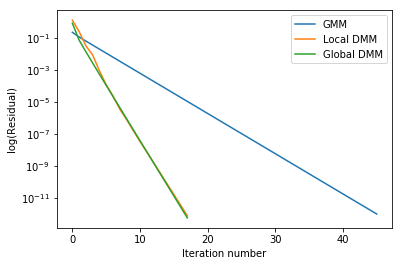

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()